# 0. Import Dependencies

In [1]:
%pip install scikit-learn
%pip install pandas
%pip install transformers

%pip install --upgrade keras


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, GPT2Tokenizer

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import os

/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
DATASET_PATH = './data/drug-review-dataset.csv'
SEED = 35

# 1. Download, Preprocess and Explore data

## Download Data

In [5]:
!mkdir ./data/
!curl -o ./data/drug-review-dataset-druglib.zip https://archive.ics.uci.edu/static/public/461/drug+review+dataset+druglib+com.zip
!unzip -o ./data/drug-review-dataset-druglib.zip -d ./data/raw-data/

mkdir: ./data/: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1106k    0 1106k    0     0   570k      0 --:--:--  0:00:01 --:--:--  570k-- 46779
Archive:  ./data/drug-review-dataset-druglib.zip
  inflating: ./data/raw-data/drugLibTest_raw.tsv  
  inflating: ./data/raw-data/drugLibTrain_raw.tsv  


In [6]:
raw_data_dir = "./data/raw-data/"
raw_data_filepaths = glob.glob(raw_data_dir + "/*.tsv")

drug_review_df = None
for filepath in raw_data_filepaths:
    df = pd.read_csv(filepath, sep="\t")
    drug_review_df = df if drug_review_df is None else pd.concat([drug_review_df, df])

drug_review_df.drop("Unnamed: 0", axis=1, inplace=True)
print(f"Dataset contains [{drug_review_df.shape[0]}] rows.")

Dataset contains [4143] rows.


## Preprocess Data

In [7]:
# Remove empty values (NANs)
print("Count NANs", drug_review_df.isna().sum(), sep="\n")
drug_review_df.dropna(inplace=True)

Count NANs
urlDrugName           0
rating                0
effectiveness         0
sideEffects           0
condition             1
benefitsReview       23
sideEffectsReview    98
commentsReview       13
dtype: int64


In [8]:
drug_review_df.to_csv(DATASET_PATH, index=False)
print(f"Dataset with [{drug_review_df.shape[0]}] rows is saved to [{DATASET_PATH}]")

Dataset with [4013] rows is saved to [./data/drug-review-dataset.csv]


## Explore Data

In [11]:
drug_review_df

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above
...,...,...,...,...,...,...,...,...
1031,accutane,7,Considerably Effective,Severe Side Effects,acne vulgaris,Detoxing effect by pushing out the system thro...,"Hairloss, extreme dry skin, itchiness, raises ...",Treatment period is 3 months/12 weeks. Dosage ...
1032,proair-hfa,10,Highly Effective,No Side Effects,asthma,"The albuterol relieved the constriction, irrit...",I have experienced no side effects.,I use the albuterol as needed because of aller...
1033,accutane,8,Considerably Effective,Moderate Side Effects,serve acne,Serve Acne has turned to middle,"Painfull muscles, problems with seeing at night","This drug is highly teratogenic ,females must ..."
1034,divigel,10,Highly Effective,No Side Effects,menopause,"My overall mood, sense of well being, energy l...",No side effects of any kind were noted or appa...,Divigel is a topically applied Bio-Identical H...


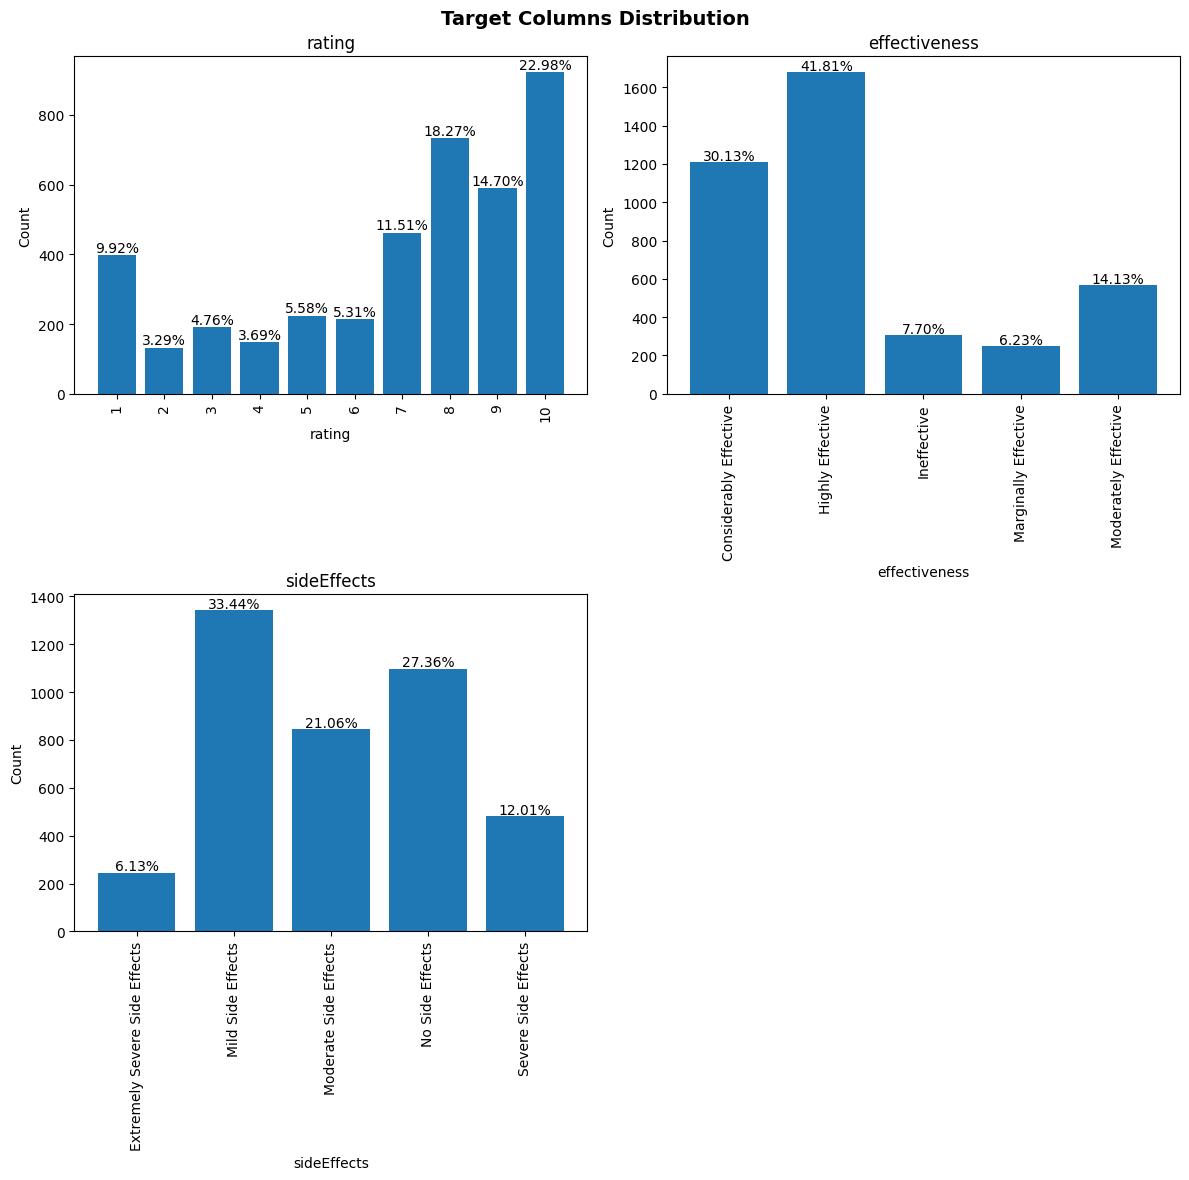

In [136]:
# add space
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

columns = ["rating", "effectiveness", "sideEffects"]
for i, col in enumerate(columns):
    ax = axes.flat[i]
    col_counts = drug_review_df[col].value_counts().sort_index()
    col_counts.index = col_counts.index.astype(str)
    
    
    ax.bar(col_counts.index, col_counts.values)
    # Add labels on top of the bars 
    for itr, v in enumerate(col_counts):
        ax.text(itr, v + 10, f'{v/drug_review_df[col].count()*100:.2f}%', color='black', ha='center')
        
    ax.set_title(col)
    ax.set_xticks(range(len(col_counts)))
    ax.set_xticklabels(col_counts.index, rotation=90, ha='center')
    ax.set_ylabel('Count')
    ax.set_xlabel(col)
    
# Hide the last subplot
axes[-1, -1].axis('off')
plt.suptitle("Target Columns Distribution", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
# Ensured the "benefitsReview", "sideEffectsReview", "commentsReview" columns are valid if they are short.

# drug_review_df.sort_values(by="benefitsReview", key=lambda col: col.str.len())[:10]
drug_review_df.sort_values(by="sideEffectsReview", key=lambda col: col.str.len())[:10]
# drug_review_df.sort_values(by="commentsReview", key=lambda col: col.str.len())[:10]

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
2767,doryx,10,Highly Effective,No Side Effects,acne,My acne was significantly reduced. My doctor a...,No,"I used birth control pills, Doryx, and topical..."
386,vyvanse,7,Considerably Effective,Moderate Side Effects,focus,..,..,"I am 27, When I was in 9th grade I became ill ..."
2326,zantac,7,Moderately Effective,No Side Effects,acid reflux,"The Ranitidine can be taken at any, time throu...",no,"may have to repeat fairly often, how ever if y..."
993,levoxyl,1,Ineffective,Extremely Severe Side Effects,hypothyroidism,Hypothyroidism was already causing me to gain ...,FAT,Doesn't work! It's the T3!
3015,zoloft,9,Considerably Effective,No Side Effects,depression,Onset of depression as a result of sudden spou...,nil,"Daily dose, reviewed quarterly by treating GP,..."
37,kapidex,8,Considerably Effective,No Side Effects,reflux,stops persistent coughs in 30 days.,non,"I tend to have persistent coughs after a cold,..."
853,lamisil,1,Marginally Effective,No Side Effects,toenail fungus,I did not see a change in the condition of the...,none,I was to take the drug for 12 weeks after havi...
2640,doryx,4,Marginally Effective,No Side Effects,acne,"mild facial improvement, healing was faster. P...",none,"once daily doryx, a time release version of do..."
375,imitrex,10,Highly Effective,No Side Effects,migraine,"Once a day, sometimes 2 in a 24 hour period de...",none,I have had migraines since I was 9 years old. ...
941,naprosyn,8,Moderately Effective,No Side Effects,arthritis,"pain relief from arthritis flare up, no stomac...",none,took once a day for 2 weeks with good results ...


# 3. Prepare Dataloaders

In [4]:
raw_drug_review_df = pd.read_csv(DATASET_PATH)
print(f"Dataset contains [{raw_drug_review_df.shape[0]}] rows.")

Dataset contains [4013] rows.


In [5]:
import re

class DrugReviewsDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, max_len):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

        if isinstance(tokenizer, Tokenizer):  # If it is a Keras Tokenizer
            self.inputs = [self.preprocess_text(i) for i in self.inputs]
            tokenizer.fit_on_texts(self.inputs)
      
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, item):
        input_item = self.inputs[item]
        target_item = self.targets[item]

        if isinstance(self.tokenizer, BertTokenizer) or isinstance(self.tokenizer, GPT2Tokenizer): # If it is a Hugging Face Tokenizer
            encoding = self.tokenizer.encode_plus(
                input_item,
                add_special_tokens=True,
                max_length=self.max_len,
                return_token_type_ids=False,
                padding='max_length', 
                return_attention_mask=True,
                return_tensors='pt',
                truncation=True,
            )
            return {
                'input_text': input_item,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'target': torch.tensor(target_item, dtype=torch.long)
            }
        else:  # If it is a Keras Tokenizer
            tokens = self.tokenizer.texts_to_sequences([input_item])
            padded_tokens = pad_sequences(tokens, maxlen=self.max_len, padding='post', truncating='post')
            return {
                'input_text': input_item,
                'input_ids': torch.tensor(padded_tokens, dtype=torch.long).flatten(),
                'target': torch.tensor(target_item, dtype=torch.long)
            }
    
    def preprocess_text(self, text):
        text = text.lower()  # Convert to lowercase
        # Remove special characters, punctuation, and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text

def create_dataloader(df, input_column, target_column, tokenizer, max_len=300, batch_size=32):
    ds = DrugReviewsDataset(
        inputs=df[input_column].to_numpy(),
        targets=df[target_column].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
    )

# Define Models

In [6]:
# Get cpu, mps or gpu device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, **kwargs):
        hidden = self.initHidden(inputs.size(0)).to(device)
        for i in range(inputs.size(1)):
            inputs_slice = inputs[:, i].unsqueeze(1)
            combined = torch.cat((inputs_slice, hidden), 1)
            hidden = self.i2h(combined)
            output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

In [8]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)  # Output activation function
        
        # Reset gate
        self.Wir = nn.Linear(input_size, hidden_size)
        self.Whir = nn.Linear(hidden_size, hidden_size)

        # Update gate
        self.Wiz = nn.Linear(input_size, hidden_size)
        self.Whz = nn.Linear(hidden_size, hidden_size)

        # New gate
        self.Win = nn.Linear(input_size, hidden_size)
        self.Whn = nn.Linear(hidden_size, hidden_size)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, inputs, **kwargs):
        hidden = self.initHidden(inputs.size(0)).to(device)
        inputs = inputs.float()
        for i in range(inputs.size(1)):
            inputs_slice = inputs[:, i].unsqueeze(1)
            r_gate = self.sig(self.Wir(inputs_slice) + self.Whir(hidden))
            z_gate = self.sig(self.Wiz(inputs_slice) + self.Whz(hidden))
            n_gate = self.tanh(self.Win(inputs_slice) + r_gate * self.Whn(hidden))
            hidden = (1 - z_gate) * n_gate + z_gate * hidden
        
        # Output is the model's prediction for the next token in the sequence.
        output = self.fc(hidden)
        output = self.softmax(output)
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

In [9]:
class GRU_2layers(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_2layers, self).__init__()

        self.hidden_size = hidden_size

        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

        # GRU layer 1
        self.Wir1 = nn.Linear(input_size, hidden_size)
        self.Whir1 = nn.Linear(hidden_size, hidden_size)
        self.Wiz1 = nn.Linear(input_size, hidden_size)
        self.Whz1 = nn.Linear(hidden_size, hidden_size)
        self.Win1 = nn.Linear(input_size, hidden_size)
        self.Whn1 = nn.Linear(hidden_size, hidden_size)

        # GRU layer 2
        self.Wir2 = nn.Linear(hidden_size, hidden_size) # The input of 2nd layer is the output of 1st layer
        self.Whir2 = nn.Linear(hidden_size, hidden_size)
        self.Wiz2 = nn.Linear(hidden_size, hidden_size) # The input of 2nd layer is the output of 1st layer
        self.Whz2 = nn.Linear(hidden_size, hidden_size)
        self.Win2 = nn.Linear(hidden_size, hidden_size) # The input of 2nd layer is the output of 1st layer
        self.Whn2 = nn.Linear(hidden_size, hidden_size)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, inputs, **kwargs):
        hidden1 = self.initHidden(inputs.size(0)).to(device)
        hidden2 = self.initHidden(inputs.size(0)).to(device)
        inputs = inputs.float()
        for i in range(inputs.size(1)):
            inputs_slice = inputs[:, i].unsqueeze(1)
            r_gate1 = self.sig(self.Wir1(inputs_slice) + self.Whir1(hidden1))
            z_gate1 = self.sig(self.Wiz1(inputs_slice) + self.Whz1(hidden1))
            n_gate1 = self.tanh(self.Win1(inputs_slice) + r_gate1 * self.Whn1(hidden1))
            hidden1 = (1 - z_gate1) * n_gate1 + z_gate1 * hidden1

            r_gate2 = self.sig(self.Wir2(hidden1) + self.Whir2(hidden2)) # The input of second layer's gate is hidden1
            z_gate2 = self.sig(self.Wiz2(hidden1) + self.Whz2(hidden2)) # The input of second layer's gate is hidden1
            n_gate2 = self.tanh(self.Win2(hidden1) + r_gate2 * self.Whn2(hidden2)) # The input of second layer's gate is hidden1
            hidden2 = (1 - z_gate2) * n_gate2 + z_gate2 * hidden2

        output = self.fc(hidden2)
        output = self.softmax(output)
        return output, hidden2

    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

        # Forget gate
        self.Wf = nn.Linear(input_size, hidden_size)
        self.Uf = nn.Linear(hidden_size, hidden_size)

        # Input gate
        self.Wi = nn.Linear(input_size, hidden_size)
        self.Ui = nn.Linear(hidden_size, hidden_size)

        # Candidate gate
        self.Wc = nn.Linear(input_size, hidden_size)
        self.Uc = nn.Linear(hidden_size, hidden_size)

        # Output gate
        self.Wo = nn.Linear(input_size, hidden_size)
        self.Uo = nn.Linear(hidden_size, hidden_size)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inputs, **kwargs):
        hidden = self.initHidden(inputs.size(0)).to(device)
        cell = self.initHidden(inputs.size(0)).to(device)
        inputs = inputs.float()
        for i in range(inputs.size(1)):
            inputs_slice = inputs[:, i].unsqueeze(1)
            f_gate = self.sig(self.Wf(inputs_slice) + self.Uf(hidden))
            i_gate = self.sig(self.Wi(inputs_slice) + self.Ui(hidden))
            c_gate = self.tanh(self.Wc(inputs_slice) + self.Uc(hidden))
            o_gate = self.sig(self.Wo(inputs_slice) + self.Uo(hidden))
            cell = f_gate * cell + i_gate * c_gate
            hidden = o_gate * self.tanh(cell)

        # Output is the model's prediction for the next token in the sequence.
        output = self.fc(hidden)
        output = self.softmax(output)

        return output, hidden
    
    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

In [11]:
from transformers import GPT2Model, GPT2Config

class GPT2Classification(GPT2Model):
    def __init__(self, n_classes):
        super().__init__(config=GPT2Config.from_pretrained("gpt2"))
        # Freeze the GPT2 layers
        for param in self.parameters():
            param.requires_grad = False

        self.linear = torch.nn.Linear(self.config.hidden_size, n_classes)
        self.softmax = torch.nn.Softmax(dim=-1)
    
    def forward(self, input_ids, attention_mask=None, past_key_values=None, **kwargs):
        transformer_outputs = super().forward(input_ids, attention_mask=attention_mask, past_key_values=past_key_values, **kwargs)
        hidden_states = transformer_outputs[0]
        logits = self.linear(hidden_states[:, -1, :])
        logits = self.softmax(logits)

        return logits, None

        

In [12]:
from transformers import BertModel, BertConfig

class BERTClassification(BertModel):
    def __init__(self, n_classes):
        super().__init__(config=BertConfig.from_pretrained("bert-base-uncased"))
        # Freeze the Bert layers
        for param in self.parameters():
            param.requires_grad = False

        self.linear = nn.Linear(self.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_ids, attention_mask=None, past_key_values=None, **kwargs):
        last_hidden_state = super().forward(input_ids, attention_mask=attention_mask, **kwargs)[0]
        logits = self.linear(last_hidden_state[:, 0, :])
        logits = self.softmax(logits)

        return logits, None

# Train Models

In [30]:
DATALOADER_CONFIGS = {
    "rating": {
        "input_column": "commentsReview",
        "target_column": "rating",
        "class_names": range(1, 11),
        "num_encoded_labels": 3,
        "max_len": 100,
    },
    "effectiveness": {
        "input_column": "commentsReview",
        "target_column": "effectiveness",
        "class_names": [
            'Ineffective',
            'Marginally Effective',
            'Moderately Effective',
            'Considerably Effective',
            'Highly Effective',
        ],
        "num_encoded_labels": 3,
        "max_len": 100,
    },
    "sideEffects": {
        "input_column": "commentsReview",
        "target_column": "sideEffects",
        "class_names": [
            'No Side Effects',
            'Mild Side Effects',
            'Moderate Side Effects',
            'Severe Side Effects',
            'Extremely Severe Side Effects',
        ],
        "num_encoded_labels": 3,
        "max_len": 100,
    }
}

In [13]:
TEST_SIZE = 0.25

def split_dataset(df, target_column, test_size=0.2):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=SEED, stratify=df[target_column])
    return train_df, test_df

def map_ratings(rating):
    if rating <= 4:
        return 0
    elif rating < 7:
        return 1
    else:
        return 2
    
def map_effectiveness(effectiveness):
    if effectiveness == 'Ineffective':
        return 0
    elif effectiveness == 'Marginally Effective':
        return 1
    elif effectiveness == 'Moderately Effective':
        return 1
    elif effectiveness == 'Considerably Effective':
        return 2
    elif effectiveness == 'Highly Effective':
        return 2

def map_side_effects(side_effects):
    if side_effects == 'No Side Effects':
        return 0
    elif side_effects == 'Mild Side Effects':
        return 1
    elif side_effects == 'Moderate Side Effects':
        return 1
    elif side_effects == 'Severe Side Effects':
        return 2
    elif side_effects == 'Extremely Severe Side Effects':
        return 2

# Map the target columns to their respective class names
mapped_drug_review_df = raw_drug_review_df.copy()
mapped_drug_review_df["rating_encoded"] = mapped_drug_review_df["rating"].map(map_ratings)
mapped_drug_review_df["effectiveness_encoded"] = mapped_drug_review_df["effectiveness"].map(map_effectiveness)
mapped_drug_review_df["sideEffects_encoded"] = mapped_drug_review_df["sideEffects"].map(map_side_effects)

# Split the dataset into training and testing sets
rating_train_df, rating_test_df = split_dataset(mapped_drug_review_df, "rating_encoded", test_size=TEST_SIZE)
effectiveness_train_df, effectiveness_test_df = split_dataset(mapped_drug_review_df, "effectiveness_encoded", test_size=TEST_SIZE)
side_effects_train_df, side_effects_test_df = split_dataset(mapped_drug_review_df, "sideEffects_encoded", test_size=TEST_SIZE)

# Create mini train and test datasets for computationally expensive models with same distribution on target columns
mini_drug_review_df = mapped_drug_review_df.sample(frac=0.1, random_state=SEED)
mini_rating_train_df, mini_rating_test_df = split_dataset(mini_drug_review_df, "rating_encoded", test_size=TEST_SIZE)
mini_effectiveness_train_df, mini_effectiveness_test_df = split_dataset(mini_drug_review_df, "effectiveness_encoded", test_size=TEST_SIZE)
mini_side_effects_train_df, mini_side_effects_test_df = split_dataset(mini_drug_review_df, "sideEffects_encoded", test_size=TEST_SIZE)

# Print the shapes of the training and testing sets
print(f"[Rating]             | Train: {rating_train_df.shape[0]} - Test: {rating_test_df.shape[0]}")
print(f"[Effectiveness]      | Train: {effectiveness_train_df.shape[0]} - Test: {effectiveness_test_df.shape[0]}")
print(f"[Side Effects]       | Train: {side_effects_train_df.shape[0]} - Test: {side_effects_test_df.shape[0]}")
print(f"[Mini Rating]        | Train: {mini_rating_train_df.shape[0]} - Test: {mini_rating_test_df.shape[0]}")
print(f"[Mini Effectiveness] | Train: {mini_effectiveness_train_df.shape[0]} - Test: {mini_effectiveness_test_df.shape[0]}")
print(f"[Mini Side Effects]  | Train: {mini_side_effects_train_df.shape[0]} - Test: {mini_side_effects_test_df.shape[0]}")

[Rating]             | Train: 3009 - Test: 1004
[Effectiveness]      | Train: 3009 - Test: 1004
[Side Effects]       | Train: 3009 - Test: 1004
[Mini Rating]        | Train: 300 - Test: 101
[Mini Effectiveness] | Train: 300 - Test: 101
[Mini Side Effects]  | Train: 300 - Test: 101


In [29]:
rating_train_df["rating_encoded"].value_counts()

rating_encoded
2    2030
0     651
1     328
Name: count, dtype: int64

In [14]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix


def validate(model, dataloader, criterion=nn.CrossEntropyLoss()):
    model.eval()
    total_loss = 0
    outputs_all = []
    targets_all = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['input_ids'].to(device)
            targets = batch['target'].to(device)
            
            attention_mask = None
            if 'attention_mask' in batch:
                attention_mask = batch['attention_mask'].to(device)
                output, *other = model(inputs, attention_mask=attention_mask)
            else:
                output, *other = model(inputs)

            loss = criterion(output, targets)

            outputs_all.extend(output.detach().cpu().numpy())
            targets_all.extend(targets.detach().cpu().numpy())
            
            total_loss += loss.item()
    
    pred = np.argmax(outputs_all, axis=1)
    return total_loss, accuracy_score(targets_all, pred)


def train(model, train_dataloader, valid_dataloader, epochs=10, lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    metrics = {
        'train_accuracy': [],
        'train_loss': [],
        'valid_accuracy': [],
        'valid_loss': [],
    }

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        outputs_all = []
        targets_all = []
        for batch in train_dataloader:
            inputs = batch['input_ids'].to(device)
            targets = batch['target'].to(device)
            optimizer.zero_grad()

            attention_mask = None
            if 'attention_mask' in batch:
                attention_mask = batch['attention_mask'].to(device)
                output, *other = model(inputs, attention_mask=attention_mask)
            else:
                output, *other = model(inputs)

            loss = criterion(output, targets)
            loss.backward()
            
            # Save all the outputs and targets for metric computation
            outputs_all.extend(output.detach().cpu().numpy())
            targets_all.extend(targets.detach().cpu().numpy())
            
            optimizer.step()
            total_loss += loss.item()

        # Compute metrics at the end of an epoch
        pred = np.argmax(outputs_all, axis=1)
        metrics['train_accuracy'].append(accuracy_score(targets_all, pred))
        metrics['train_loss'].append(total_loss)

        # Validation
        valid_loss, valid_accuracy = validate(model, valid_dataloader, criterion)
        metrics['valid_accuracy'].append(valid_accuracy)
        metrics['valid_loss'].append(valid_loss)
        
        print(f"[{epoch + 1}/{epochs}] | Train Loss: [{total_loss:.4f}] | Train Accuracy: [{metrics['train_accuracy'][-1]:.4f}] | Valid Loss: [{valid_loss:.4f}] | Valid Accuracy: [{valid_accuracy:.4f}]")

    return metrics

In [37]:
from scipy.special import softmax

def test_model(model, test_dataloader):
    model.eval()
    outputs_all = []
    targets_all = []
    with torch.no_grad():
        for batch in test_dataloader:
            inputs = batch['input_ids'].to(device)
            targets = batch['target'].to(device)

            attention_mask = None
            if 'attention_mask' in batch:
                attention_mask = batch['attention_mask'].to(device)
                output, *other = model(inputs, attention_mask=attention_mask)
            else:
                output, *other = model(inputs)

            output = softmax(output.detach().cpu().numpy(), axis=1)  # Convert to probabilities using softmax
            outputs_all.extend(output)
            targets_all.extend(targets.detach().cpu().numpy())
    
    print("outputs_all shape", len(outputs_all), len(outputs_all[0]))
    print("targets_all shape", len(targets_all))
    
    pred = np.argmax(outputs_all, axis=1)
    return {
        'accuracy': accuracy_score(targets_all, pred),
        'balanced_accuracy': balanced_accuracy_score(targets_all, pred),
        'f1': f1_score(targets_all, pred, average='weighted'),
        'roc_auc': roc_auc_score(targets_all, outputs_all, average='weighted', multi_class='ovr'),
        'precision': precision_score(targets_all, pred, average='weighted'),
        'recall': recall_score(targets_all, pred, average='weighted'),
        'confusion_matrix': confusion_matrix(targets_all, pred),
    }

def plot_metrics(metrics, class_names=range(3)):
    """Print and plot accuracy, balanced_accuracy, f1, roc_auc, precision, recall, and confusion matrix for multiclassification problems"""

    # Print the metrics
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    print(f"F1: {metrics['f1']:.4f}")
    print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(metrics['confusion_matrix'])

    # Show all ticks
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, metrics['confusion_matrix'][i, j], ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    fig.tight_layout()
    plt.show()
    
    

In [16]:
def run_training(
        model_path,
        model,
        train_dataloader,
        test_dataloader,
        epochs=10,
        lr=0.001,
        save_model=True
):
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Loaded model from {model_path}")

    print(f"Training {model_path} model...")
    metrics = train(model, train_dataloader, test_dataloader, epochs=epochs, lr=lr)
    if save_model:
        torch.save(model.state_dict(), model_path)
    return model, metrics

In [17]:
def plot_losses(metrics):
    """The train learning curves must be in blue and the test curves - in red."""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    axes[0].plot(metrics['train_loss'], label='Train Loss', color='blue')
    axes[0].plot(metrics['valid_loss'], label='Valid Loss', color='red')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(metrics['train_accuracy'], label='Train Accuracy', color='blue')
    axes[1].plot(metrics['valid_accuracy'], label='Valid Accuracy', color='red')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

### RNN

In [31]:
BATCH_SIZE = 32
rnn_tokenizer = Tokenizer()
rnn_rating_train_dataloader = create_dataloader(rating_train_df, "commentsReview", "rating_encoded", rnn_tokenizer, batch_size=BATCH_SIZE)
rnn_rating_test_dataloader = create_dataloader(rating_test_df, "commentsReview", "rating_encoded", rnn_tokenizer, batch_size=BATCH_SIZE)
rnn_effectiveness_train_dataloader = create_dataloader(effectiveness_train_df, "commentsReview", "effectiveness_encoded", rnn_tokenizer, batch_size=BATCH_SIZE)
rnn_effectiveness_test_dataloader = create_dataloader(effectiveness_test_df, "commentsReview", "effectiveness_encoded", rnn_tokenizer, batch_size=BATCH_SIZE)
rnn_side_effects_train_dataloader = create_dataloader(side_effects_train_df, "commentsReview", "sideEffects_encoded", rnn_tokenizer, batch_size=BATCH_SIZE)
rnn_side_effects_test_dataloader = create_dataloader(side_effects_test_df, "commentsReview", "sideEffects_encoded", rnn_tokenizer, batch_size=BATCH_SIZE)

Training ./models/rnn_rating_model.pth model...
[1/10] | Train Loss: [152.5869] | Train Accuracy: [0.6746] | Valid Loss: [36.0054] | Valid Accuracy: [0.6733]
[2/10] | Train Loss: [103.3117] | Train Accuracy: [0.6746] | Valid Loss: [31.3561] | Valid Accuracy: [0.6753]
[3/10] | Train Loss: [96.0556] | Train Accuracy: [0.6753] | Valid Loss: [32.3746] | Valid Accuracy: [0.6753]
[4/10] | Train Loss: [96.3502] | Train Accuracy: [0.6750] | Valid Loss: [31.4402] | Valid Accuracy: [0.6743]
[5/10] | Train Loss: [93.5761] | Train Accuracy: [0.6756] | Valid Loss: [31.6486] | Valid Accuracy: [0.6743]
[6/10] | Train Loss: [92.5912] | Train Accuracy: [0.6753] | Valid Loss: [38.9056] | Valid Accuracy: [0.6723]
[7/10] | Train Loss: [99.1082] | Train Accuracy: [0.6750] | Valid Loss: [31.8256] | Valid Accuracy: [0.6743]
[8/10] | Train Loss: [94.1284] | Train Accuracy: [0.6753] | Valid Loss: [30.1167] | Valid Accuracy: [0.6733]
[9/10] | Train Loss: [94.5723] | Train Accuracy: [0.6753] | Valid Loss: [33.49

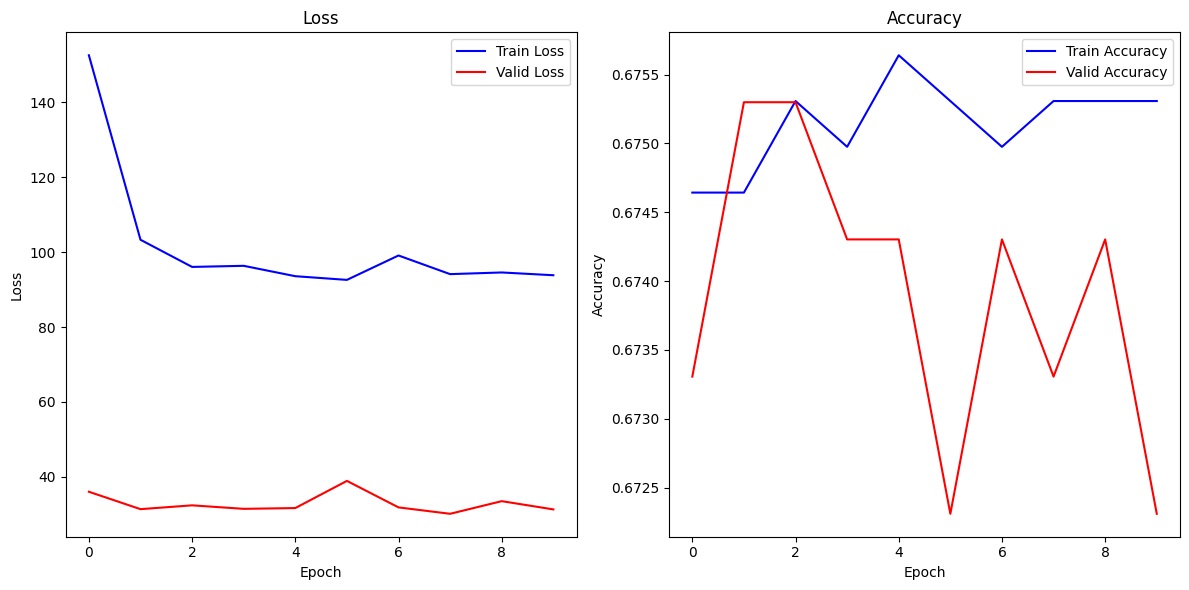

In [32]:
rnn_rating_model, rnn_rating_train_metrics = run_training(
    model_path="./models/rnn_rating_model.pth",
    model=RNN(input_size=1, hidden_size=16, output_size=DATALOADER_CONFIGS["rating"]["num_encoded_labels"]),
    train_dataloader=rnn_rating_train_dataloader,
    test_dataloader=rnn_rating_test_dataloader,
    epochs=10,
    lr=0.01,
    save_model=True
)

plot_losses(rnn_rating_train_metrics)

outputs_all shape 1004 3
targets_all shape 1004
Accuracy: 0.6723
Balanced Accuracy: 0.3334
F1: 0.5440
ROC AUC: 0.4802
Precision: 0.5088
Recall: 0.6723


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


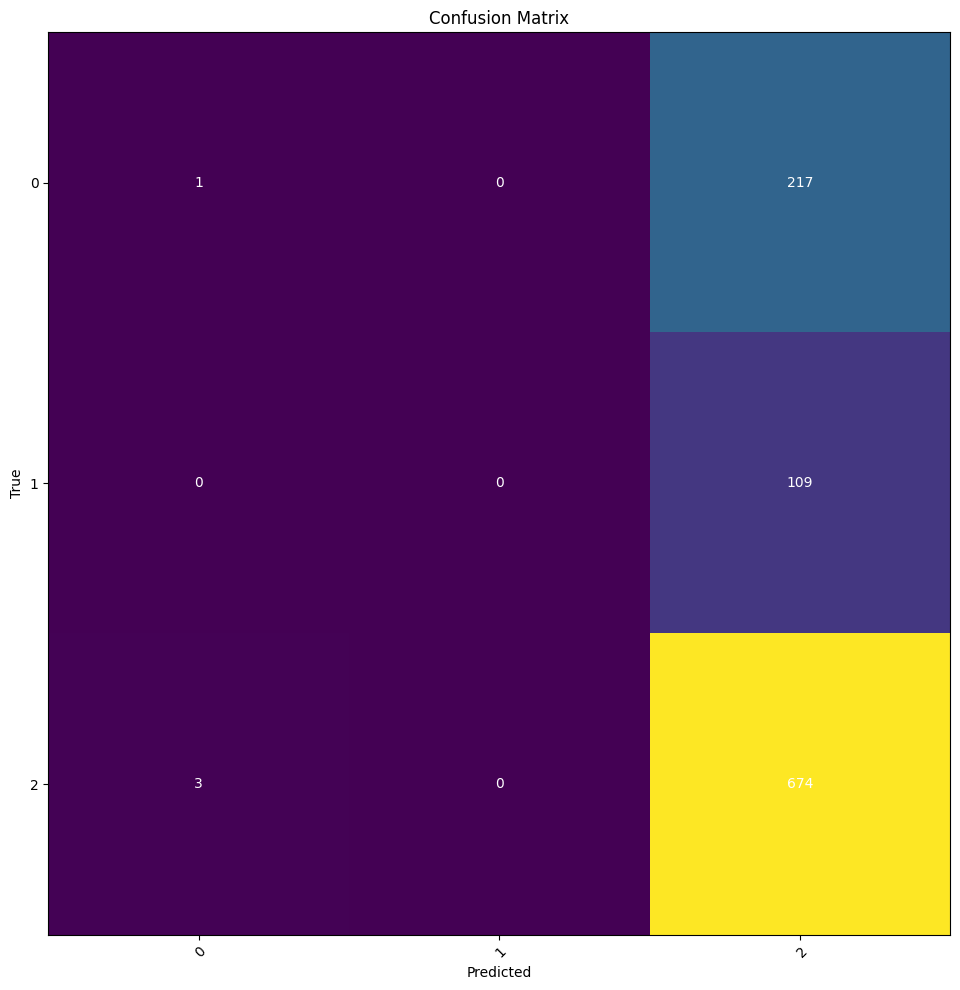

In [38]:
rnn_rating_test_metrics = test_model(
    rnn_rating_model,
    rnn_rating_test_dataloader
)

plot_metrics(rnn_rating_test_metrics)

Training ./models/rnn_effectiveness_model.pth model...
[1/10] | Train Loss: [155.3116] | Train Accuracy: [0.7178] | Valid Loss: [32.7905] | Valid Accuracy: [0.7181]
[2/10] | Train Loss: [87.3157] | Train Accuracy: [0.7168] | Valid Loss: [38.3310] | Valid Accuracy: [0.7191]
[3/10] | Train Loss: [90.0933] | Train Accuracy: [0.7172] | Valid Loss: [41.6683] | Valid Accuracy: [0.7191]
[4/10] | Train Loss: [81.0882] | Train Accuracy: [0.7185] | Valid Loss: [56.3529] | Valid Accuracy: [0.7191]
[5/10] | Train Loss: [79.4307] | Train Accuracy: [0.7182] | Valid Loss: [42.1766] | Valid Accuracy: [0.7191]
[6/10] | Train Loss: [83.7397] | Train Accuracy: [0.7172] | Valid Loss: [52.9434] | Valid Accuracy: [0.7191]
[7/10] | Train Loss: [84.7399] | Train Accuracy: [0.7175] | Valid Loss: [65.8185] | Valid Accuracy: [0.7191]
[8/10] | Train Loss: [80.5984] | Train Accuracy: [0.7178] | Valid Loss: [49.4576] | Valid Accuracy: [0.7191]
[9/10] | Train Loss: [87.5513] | Train Accuracy: [0.7172] | Valid Loss: 

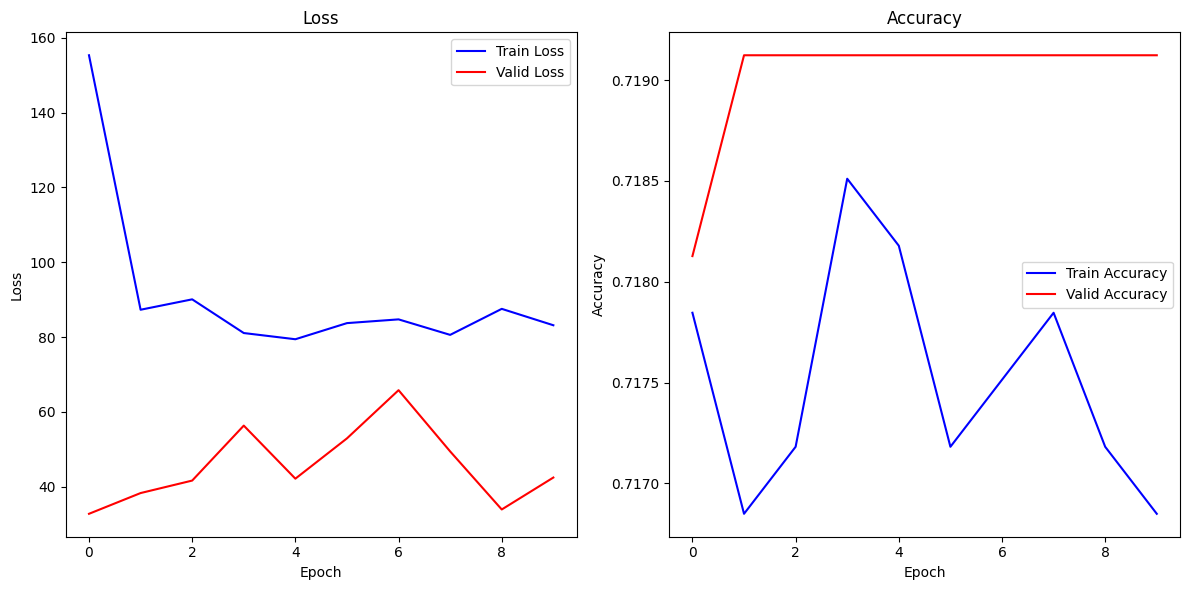

In [39]:
rnn_effectiveness_model, rnn_effectiveness_train_metrics = run_training(
    model_path="./models/rnn_effectiveness_model.pth",
    model=RNN(input_size=1, hidden_size=16, output_size=DATALOADER_CONFIGS["effectiveness"]["num_encoded_labels"]),
    train_dataloader=rnn_effectiveness_train_dataloader,
    test_dataloader=rnn_effectiveness_test_dataloader,
    epochs=10,
    lr=0.01,
    save_model=True
)

plot_losses(rnn_effectiveness_train_metrics)

outputs_all shape 1004 3
targets_all shape 1004
Accuracy: 0.7191
Balanced Accuracy: 0.3345
F1: 0.6038
ROC AUC: 0.5027
Precision: 0.5860
Recall: 0.7191


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


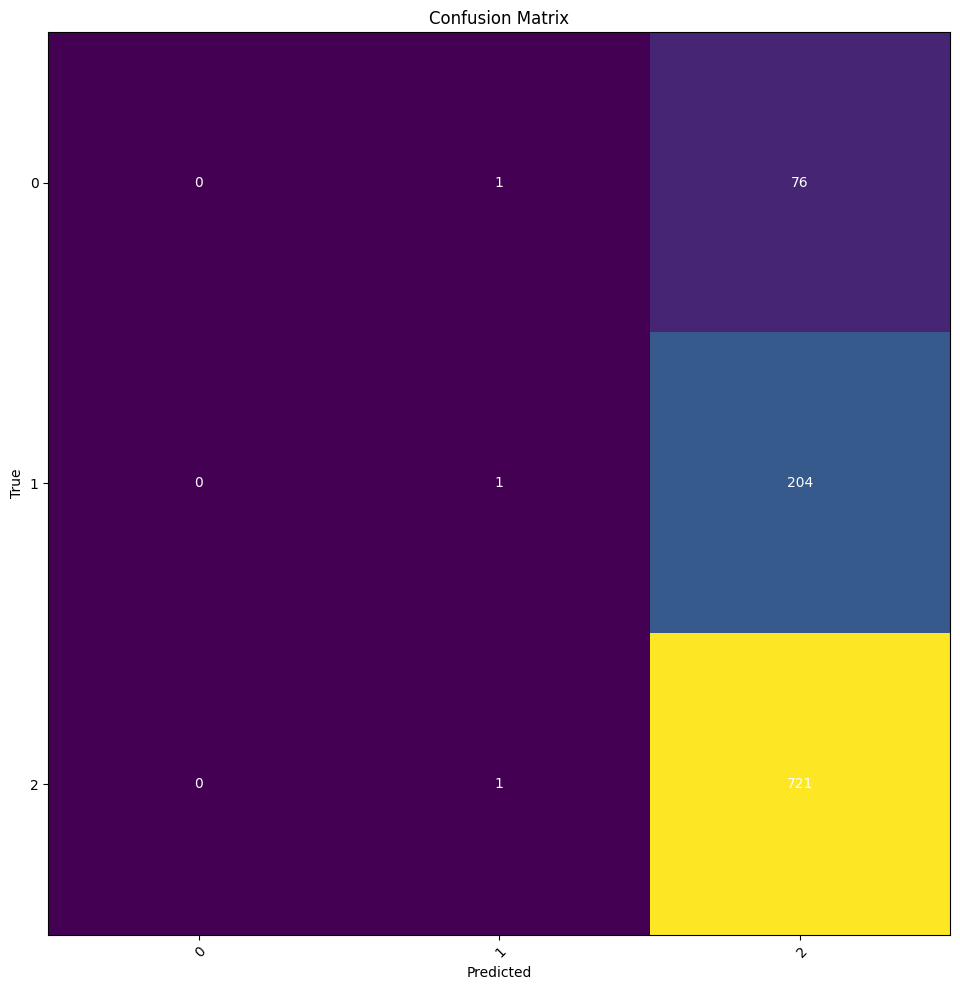

In [40]:
rnn_effectiveness_test_metrics = test_model(
    rnn_effectiveness_model,
    rnn_effectiveness_test_dataloader
)

plot_metrics(rnn_effectiveness_test_metrics)

Training ./models/rnn_side_effects_model.pth model...
[1/10] | Train Loss: [118.1036] | Train Accuracy: [0.5387] | Valid Loss: [34.3402] | Valid Accuracy: [0.5488]
[2/10] | Train Loss: [109.6837] | Train Accuracy: [0.5450] | Valid Loss: [35.4436] | Valid Accuracy: [0.5468]
[3/10] | Train Loss: [98.5065] | Train Accuracy: [0.5444] | Valid Loss: [36.3555] | Valid Accuracy: [0.5458]
[4/10] | Train Loss: [97.7880] | Train Accuracy: [0.5447] | Valid Loss: [34.6874] | Valid Accuracy: [0.5488]
[5/10] | Train Loss: [96.9611] | Train Accuracy: [0.5450] | Valid Loss: [36.7229] | Valid Accuracy: [0.5468]
[6/10] | Train Loss: [96.3463] | Train Accuracy: [0.5454] | Valid Loss: [34.1865] | Valid Accuracy: [0.5458]
[7/10] | Train Loss: [95.7258] | Train Accuracy: [0.5454] | Valid Loss: [33.2529] | Valid Accuracy: [0.5478]
[8/10] | Train Loss: [95.7256] | Train Accuracy: [0.5457] | Valid Loss: [33.3214] | Valid Accuracy: [0.5468]
[9/10] | Train Loss: [95.7302] | Train Accuracy: [0.5457] | Valid Loss: 

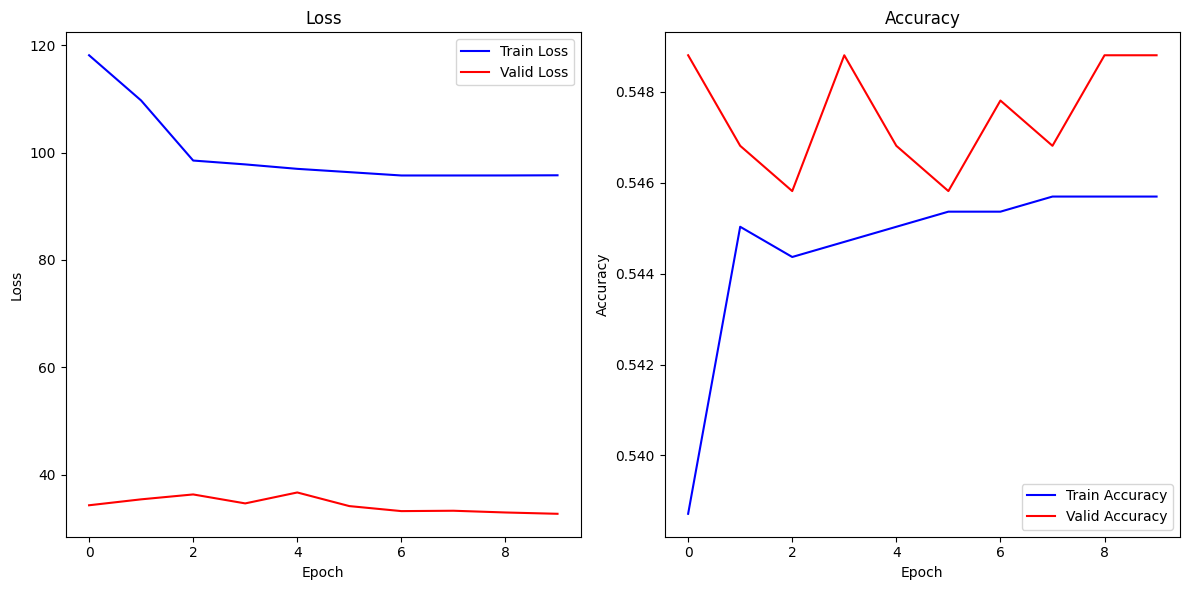

In [41]:
rnn_side_effects_model, rnn_side_effects_train_metrics = run_training(
    model_path="./models/rnn_side_effects_model.pth",
    model=RNN(input_size=1, hidden_size=16, output_size=DATALOADER_CONFIGS["sideEffects"]["num_encoded_labels"]),
    train_dataloader=rnn_side_effects_train_dataloader,
    test_dataloader=rnn_side_effects_test_dataloader,
    epochs=10,
    lr=0.01,
    save_model=True
)

plot_losses(rnn_side_effects_train_metrics)

outputs_all shape 1004 3
targets_all shape 1004
Accuracy: 0.5488
Balanced Accuracy: 0.3407
F1: 0.3931
ROC AUC: 0.5053
Precision: 0.4793
Recall: 0.5488


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


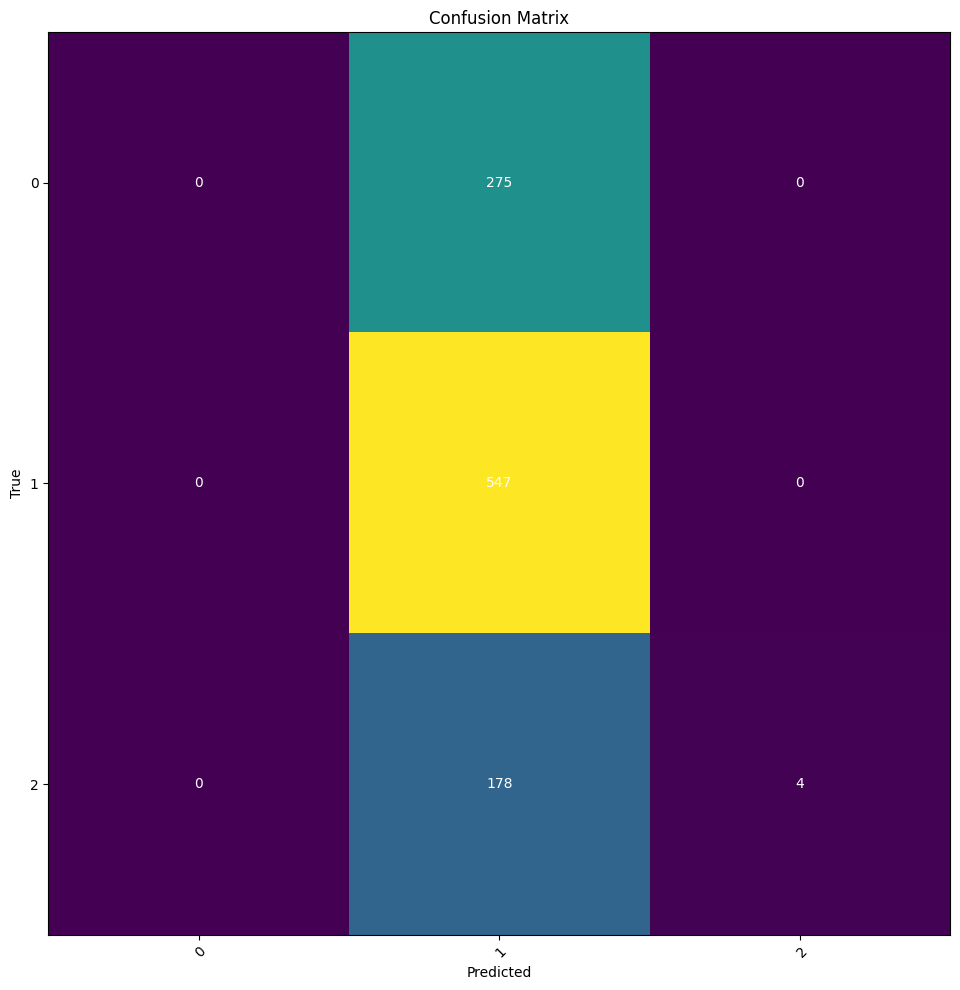

In [42]:
rnn_side_effects_test_metrics = test_model(
    rnn_side_effects_model,
    rnn_side_effects_test_dataloader
)

plot_metrics(rnn_side_effects_test_metrics)

### GRU

In [432]:
BATCH_SIZE = 32
gru_tokenizer = Tokenizer()
mini_gru_rating_train_dataloader = create_dataloader(mini_rating_train_df, "commentsReview", "rating_encoded", gru_tokenizer, batch_size=BATCH_SIZE)
mini_gru_rating_test_dataloader = create_dataloader(mini_rating_test_df, "commentsReview", "rating_encoded", gru_tokenizer, batch_size=BATCH_SIZE)
mini_gru_effectiveness_train_dataloader = create_dataloader(mini_effectiveness_train_df, "commentsReview", "effectiveness_encoded", gru_tokenizer, batch_size=BATCH_SIZE)
mini_gru_effectiveness_test_dataloader = create_dataloader(mini_effectiveness_test_df, "commentsReview", "effectiveness_encoded", gru_tokenizer, batch_size=BATCH_SIZE)
mini_gru_side_effects_train_dataloader = create_dataloader(mini_side_effects_train_df, "commentsReview", "sideEffects_encoded", gru_tokenizer, batch_size=BATCH_SIZE)
mini_gru_side_effects_test_dataloader = create_dataloader(mini_side_effects_test_df, "commentsReview", "sideEffects_encoded", gru_tokenizer, batch_size=BATCH_SIZE)


Training ./models/gru_rating_model.pth model...
[1/10] | Train Loss: [23.0533] | Train Accuracy: [0.1100] | Valid Loss: [9.1932] | Valid Accuracy: [0.1089]
[2/10] | Train Loss: [22.9786] | Train Accuracy: [0.1100] | Valid Loss: [9.1642] | Valid Accuracy: [0.1089]
[3/10] | Train Loss: [22.8921] | Train Accuracy: [0.1100] | Valid Loss: [9.1301] | Valid Accuracy: [0.1089]
[4/10] | Train Loss: [22.7847] | Train Accuracy: [0.2033] | Valid Loss: [9.0891] | Valid Accuracy: [0.2376]
[5/10] | Train Loss: [22.6533] | Train Accuracy: [0.2367] | Valid Loss: [9.0417] | Valid Accuracy: [0.2376]
[6/10] | Train Loss: [22.5063] | Train Accuracy: [0.2367] | Valid Loss: [8.9935] | Valid Accuracy: [0.2376]
[7/10] | Train Loss: [22.3691] | Train Accuracy: [0.2367] | Valid Loss: [8.9552] | Valid Accuracy: [0.2376]
[8/10] | Train Loss: [22.2714] | Train Accuracy: [0.2367] | Valid Loss: [8.9330] | Valid Accuracy: [0.2376]
[9/10] | Train Loss: [22.2178] | Train Accuracy: [0.2367] | Valid Loss: [8.9228] | Valid

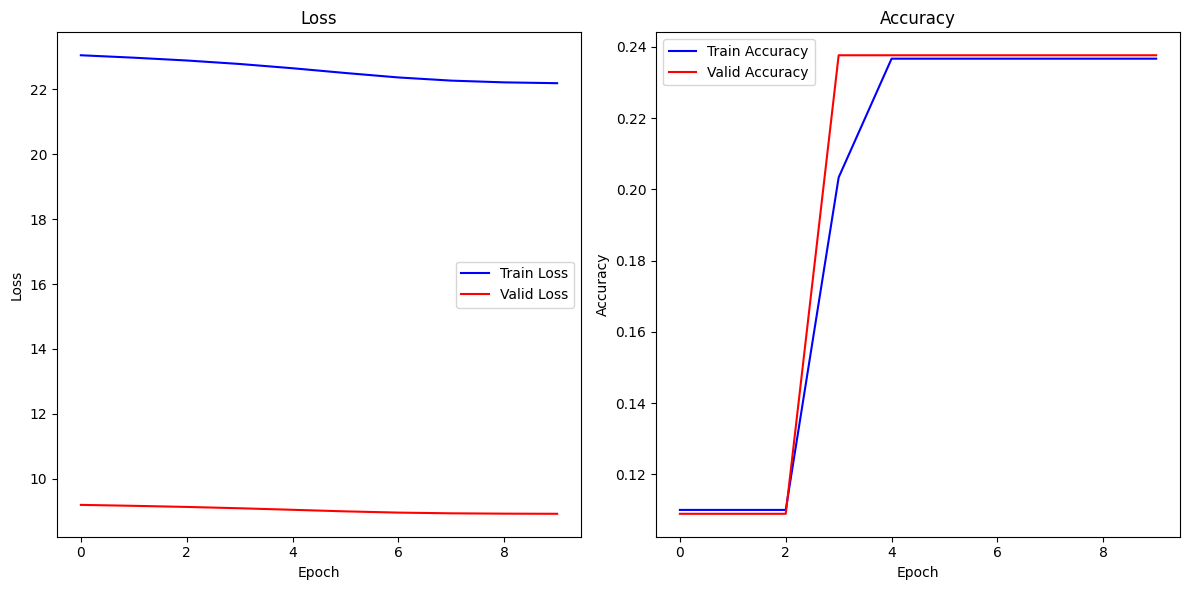

In [433]:
gru_rating_model, gru_rating_train_metrics = run_training(
    model_path="./models/gru_rating_model.pth",
    model=GRU(input_size=1, hidden_size=32, output_size=DATALOADER_CONFIGS["rating"]["num_encoded_labels"]),
    train_dataloader=mini_gru_rating_train_dataloader,
    test_dataloader=mini_gru_rating_test_dataloader,
    epochs=10,
    lr=0.001,
    save_model=True
)

plot_losses(gru_rating_train_metrics)

/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.2376
Balanced Accuracy: 0.1000
F1: 0.0912
ROC AUC: 0.5001
Precision: 0.0565
Recall: 0.2376


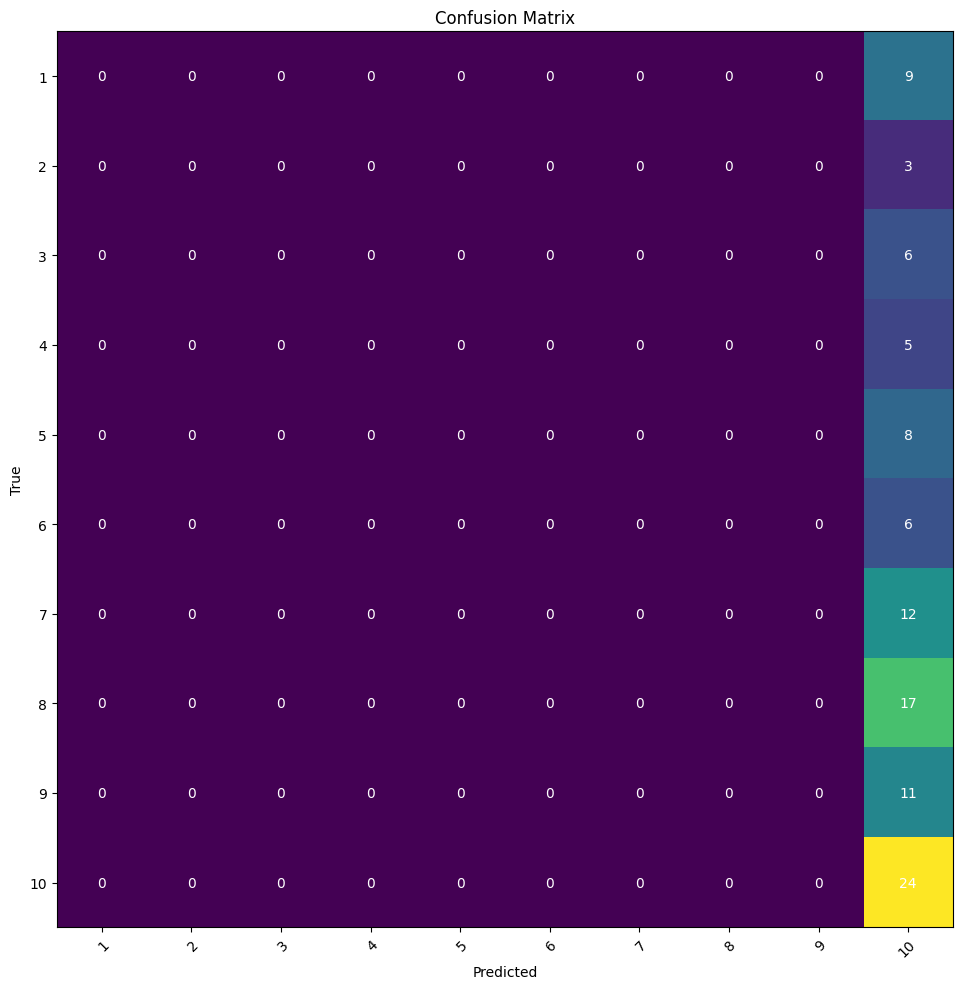

In [434]:
gru_rating_test_metrics = test_model(
    gru_rating_model,
    mini_gru_rating_test_dataloader
)

plot_metrics(gru_rating_test_metrics)

Training ./models/gru_effectiveness_model.pth model...
[1/10] | Train Loss: [15.9009] | Train Accuracy: [0.2967] | Valid Loss: [6.3216] | Valid Accuracy: [0.2970]
[2/10] | Train Loss: [15.6770] | Train Accuracy: [0.2967] | Valid Loss: [6.2446] | Valid Accuracy: [0.2970]
[3/10] | Train Loss: [15.4891] | Train Accuracy: [0.2967] | Valid Loss: [6.1797] | Valid Accuracy: [0.2970]
[4/10] | Train Loss: [15.3323] | Train Accuracy: [0.3067] | Valid Loss: [6.1224] | Valid Accuracy: [0.3861]
[5/10] | Train Loss: [15.1993] | Train Accuracy: [0.3900] | Valid Loss: [6.0724] | Valid Accuracy: [0.3861]
[6/10] | Train Loss: [15.0945] | Train Accuracy: [0.3900] | Valid Loss: [6.0358] | Valid Accuracy: [0.3861]
[7/10] | Train Loss: [15.0262] | Train Accuracy: [0.3900] | Valid Loss: [6.0151] | Valid Accuracy: [0.3861]
[8/10] | Train Loss: [14.9887] | Train Accuracy: [0.3900] | Valid Loss: [6.0050] | Valid Accuracy: [0.3861]
[9/10] | Train Loss: [14.9681] | Train Accuracy: [0.3900] | Valid Loss: [6.0000] 

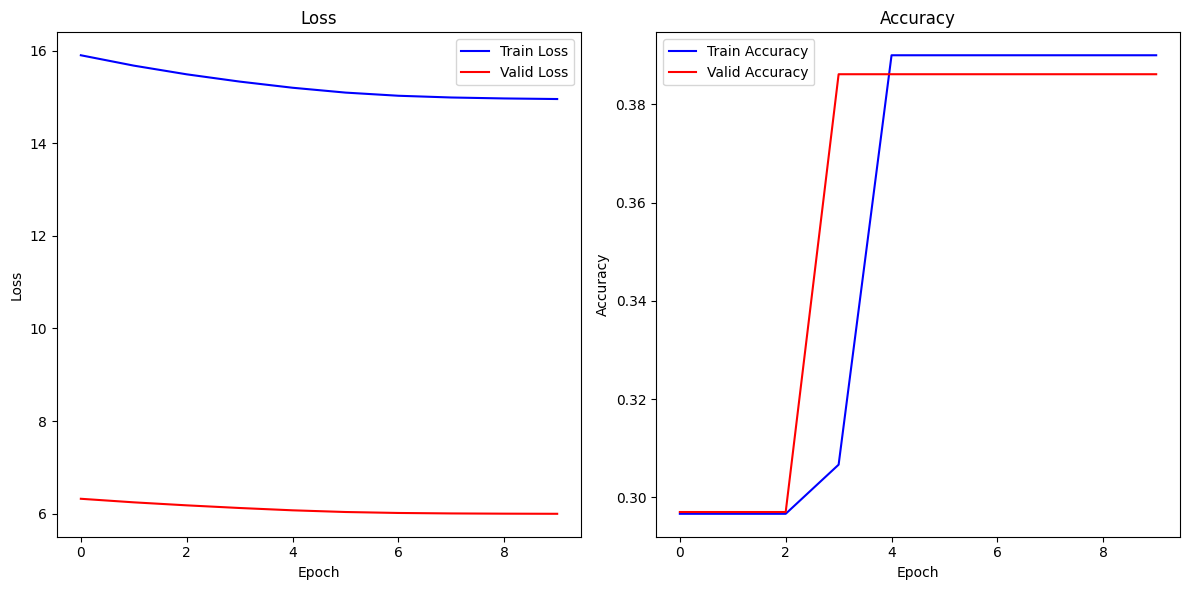

/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.3861
Balanced Accuracy: 0.2000
F1: 0.2151
ROC AUC: 0.5031
Precision: 0.1491
Recall: 0.3861


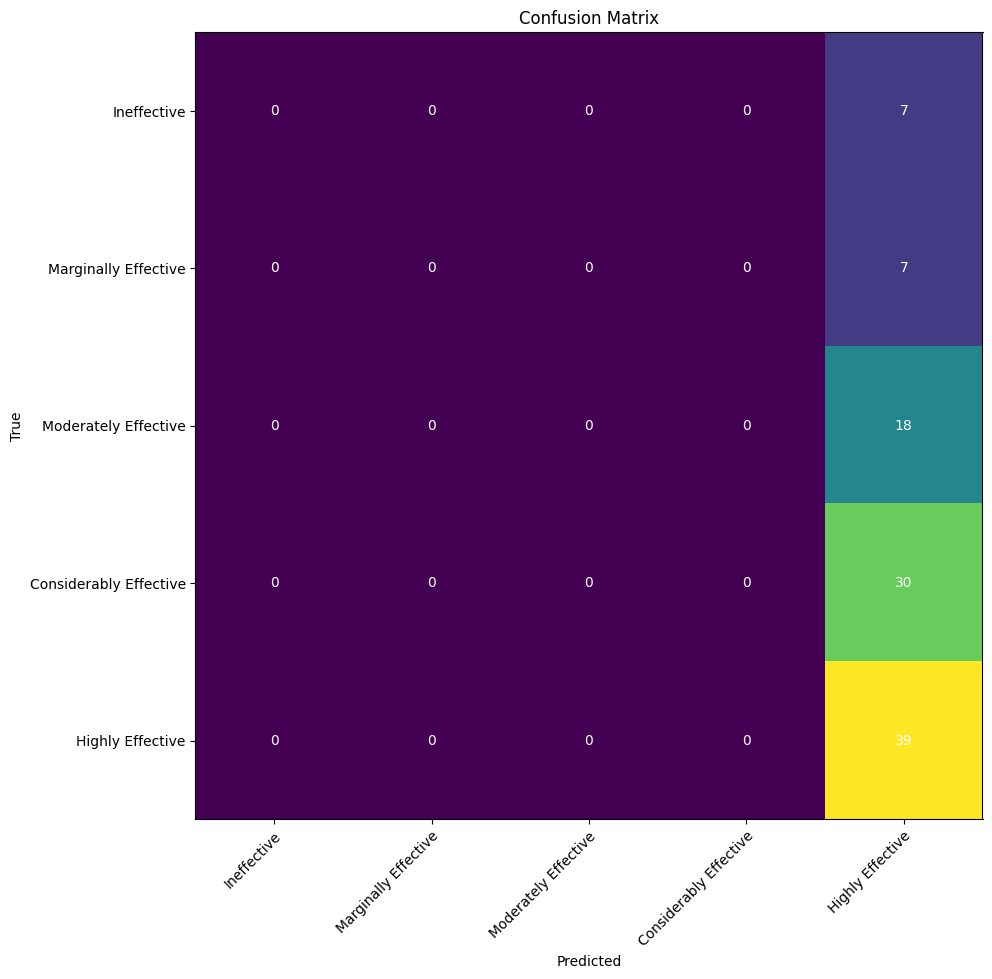

In [435]:
gru_effectiveness_model, gru_effectiveness_train_metrics = run_training(
    model_path="./models/gru_effectiveness_model.pth",
    model=GRU(input_size=1, hidden_size=32, output_size=DATALOADER_CONFIGS["effectiveness"]["num_encoded_labels"]),
    train_dataloader=mini_gru_effectiveness_train_dataloader,
    test_dataloader=mini_gru_effectiveness_test_dataloader,
    epochs=10,
    lr=0.001,
    save_model=True
)

plot_losses(gru_effectiveness_train_metrics)

gru_effectiveness_test_metrics = test_model(
    gru_effectiveness_model,
    mini_gru_effectiveness_test_dataloader
)

plot_metrics(gru_effectiveness_test_metrics, DATALOADER_CONFIGS["effectiveness"]["class_names"])

Training ./models/gru_side_effects_model.pth model...
[1/10] | Train Loss: [16.1320] | Train Accuracy: [0.1833] | Valid Loss: [6.4186] | Valid Accuracy: [0.2376]
[2/10] | Train Loss: [15.9645] | Train Accuracy: [0.2367] | Valid Loss: [6.3627] | Valid Accuracy: [0.2376]
[3/10] | Train Loss: [15.8229] | Train Accuracy: [0.2700] | Valid Loss: [6.3164] | Valid Accuracy: [0.3069]
[4/10] | Train Loss: [15.7047] | Train Accuracy: [0.3100] | Valid Loss: [6.2792] | Valid Accuracy: [0.3069]
[5/10] | Train Loss: [15.6105] | Train Accuracy: [0.3100] | Valid Loss: [6.2518] | Valid Accuracy: [0.3069]
[6/10] | Train Loss: [15.5433] | Train Accuracy: [0.3100] | Valid Loss: [6.2343] | Valid Accuracy: [0.3069]
[7/10] | Train Loss: [15.5029] | Train Accuracy: [0.3100] | Valid Loss: [6.2239] | Valid Accuracy: [0.3069]
[8/10] | Train Loss: [15.4808] | Train Accuracy: [0.3100] | Valid Loss: [6.2163] | Valid Accuracy: [0.3069]
[9/10] | Train Loss: [15.4677] | Train Accuracy: [0.3100] | Valid Loss: [6.2096] |

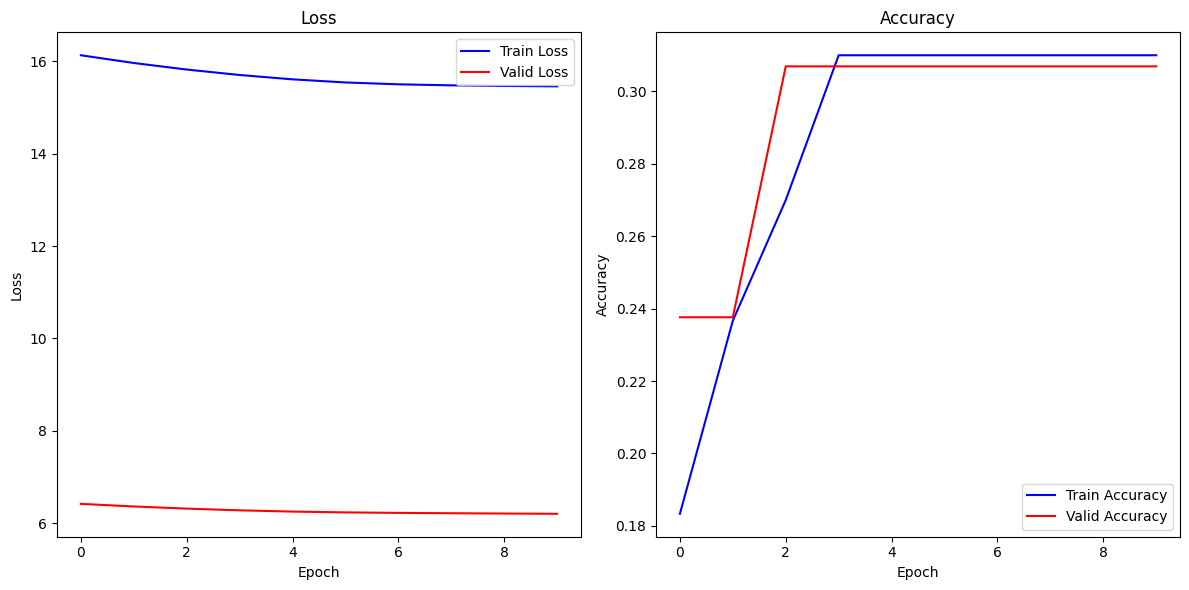

/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.3069
Balanced Accuracy: 0.2000
F1: 0.1442
ROC AUC: 0.5037
Precision: 0.0942
Recall: 0.3069


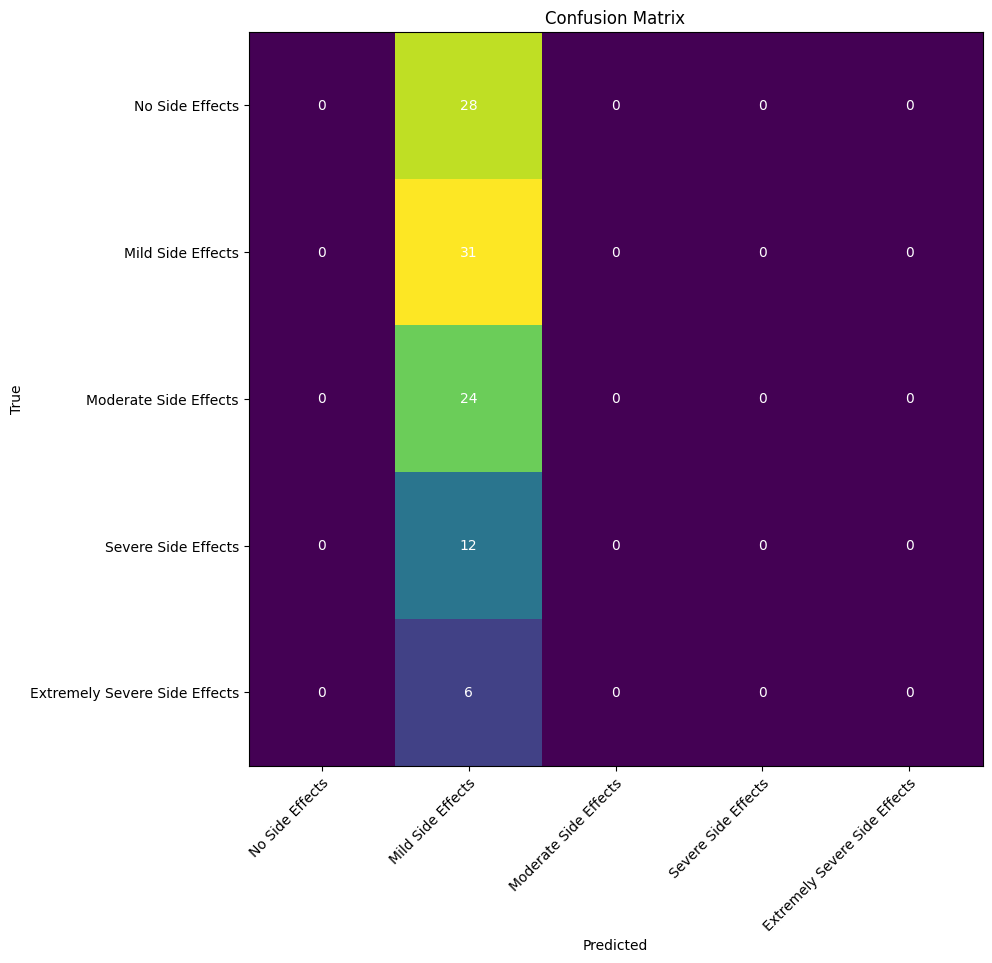

In [436]:
gru_side_effects_model, gru_side_effects_train_metrics = run_training(
    model_path="./models/gru_side_effects_model.pth",
    model=GRU(input_size=1, hidden_size=32, output_size=DATALOADER_CONFIGS["sideEffects"]["num_encoded_labels"]),
    train_dataloader=mini_gru_side_effects_train_dataloader,
    test_dataloader=mini_gru_side_effects_test_dataloader,
    epochs=10,
    lr=0.001,
    save_model=True
)

plot_losses(gru_side_effects_train_metrics)

gru_side_effects_test_metrics = test_model(

    gru_side_effects_model,
    mini_gru_side_effects_test_dataloader
)

plot_metrics(gru_side_effects_test_metrics, DATALOADER_CONFIGS["sideEffects"]["class_names"])

### GRU 2-layered

In [43]:
BATCH_SIZE = 32
gru_2layers_tokenizer = Tokenizer()
mini_gru_2layers_rating_train_dataloader = create_dataloader(mini_rating_train_df, "commentsReview", "rating_encoded", gru_2layers_tokenizer, batch_size=BATCH_SIZE)
mini_gru_2layers_rating_test_dataloader = create_dataloader(mini_rating_test_df, "commentsReview", "rating_encoded", gru_2layers_tokenizer, batch_size=BATCH_SIZE)
mini_gru_2layers_effectiveness_train_dataloader = create_dataloader(mini_effectiveness_train_df, "commentsReview", "effectiveness_encoded", gru_2layers_tokenizer, batch_size=BATCH_SIZE)
mini_gru_2layers_effectiveness_test_dataloader = create_dataloader(mini_effectiveness_test_df, "commentsReview", "effectiveness_encoded", gru_2layers_tokenizer, batch_size=BATCH_SIZE)
mini_gru_2layers_side_effects_train_dataloader = create_dataloader(mini_side_effects_train_df, "commentsReview", "sideEffects_encoded", gru_2layers_tokenizer, batch_size=BATCH_SIZE)
mini_gru_2layers_side_effects_test_dataloader = create_dataloader(mini_side_effects_test_df, "commentsReview", "sideEffects_encoded", gru_2layers_tokenizer, batch_size=BATCH_SIZE)

Training ./models/gru_2layers_rating_model.pth model...
[1/10] | Train Loss: [9.5857] | Train Accuracy: [0.6233] | Valid Loss: [3.4054] | Valid Accuracy: [0.6238]
[2/10] | Train Loss: [9.1579] | Train Accuracy: [0.6233] | Valid Loss: [3.3964] | Valid Accuracy: [0.6238]
[3/10] | Train Loss: [9.1523] | Train Accuracy: [0.6233] | Valid Loss: [3.3949] | Valid Accuracy: [0.6238]
[4/10] | Train Loss: [9.1513] | Train Accuracy: [0.6233] | Valid Loss: [3.3944] | Valid Accuracy: [0.6238]
[5/10] | Train Loss: [9.1509] | Train Accuracy: [0.6233] | Valid Loss: [3.3942] | Valid Accuracy: [0.6238]
[6/10] | Train Loss: [9.1508] | Train Accuracy: [0.6233] | Valid Loss: [3.3941] | Valid Accuracy: [0.6238]
[7/10] | Train Loss: [9.1506] | Train Accuracy: [0.6233] | Valid Loss: [3.3940] | Valid Accuracy: [0.6238]
[8/10] | Train Loss: [9.1506] | Train Accuracy: [0.6233] | Valid Loss: [3.3939] | Valid Accuracy: [0.6238]
[9/10] | Train Loss: [9.1505] | Train Accuracy: [0.6233] | Valid Loss: [3.3939] | Valid 

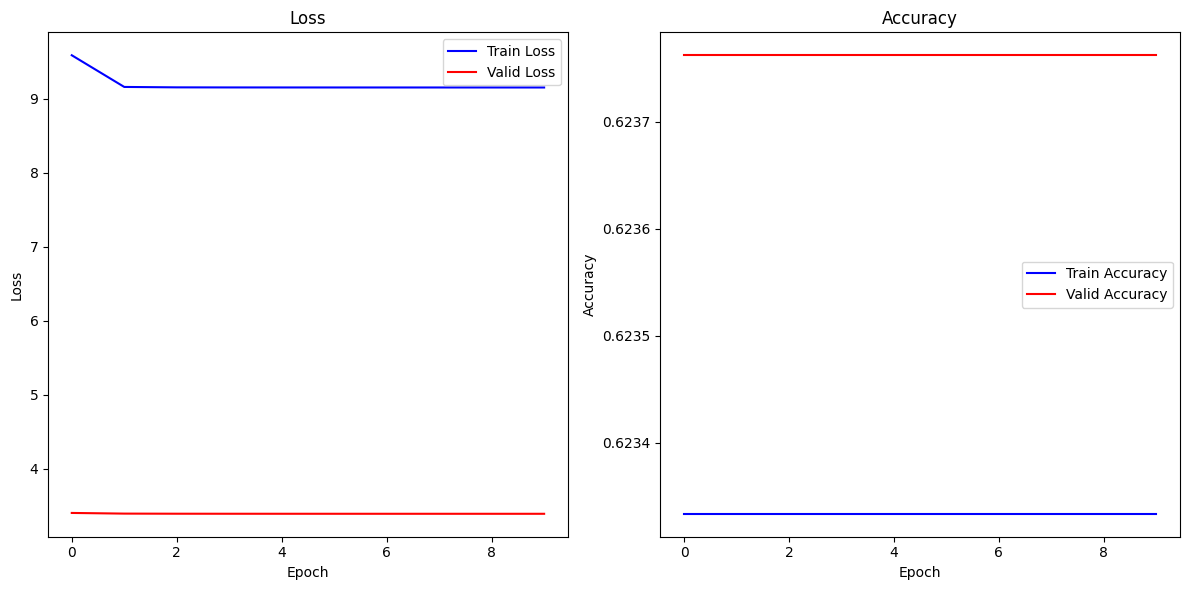

outputs_all shape 101 3
targets_all shape 101
Accuracy: 0.6238
Balanced Accuracy: 0.3333
F1: 0.4792
ROC AUC: 0.4443
Precision: 0.3891
Recall: 0.6238


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


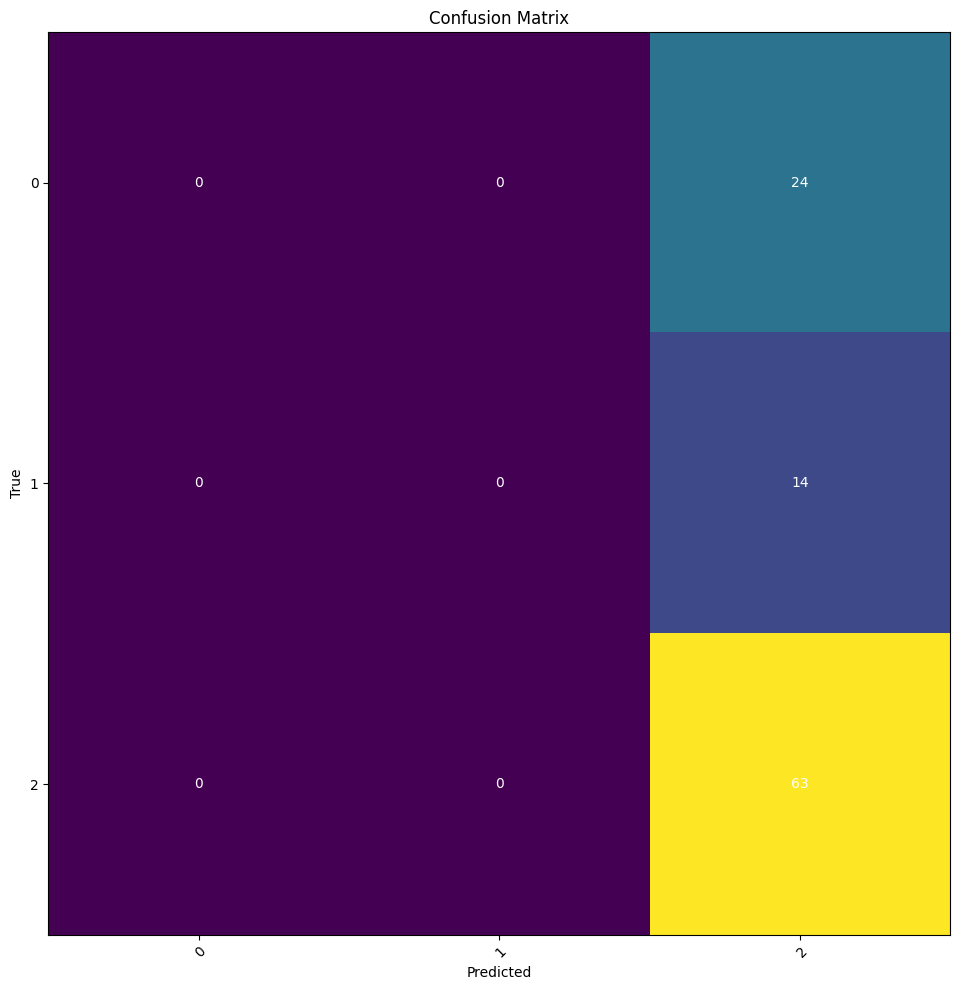

In [48]:
mini_gru_2layers_rating_model, mini_gru_2layers_rating_train_metrics = run_training(
    model_path="./models/gru_2layers_rating_model.pth",
    model=GRU_2layers(input_size=1, hidden_size=32, output_size=DATALOADER_CONFIGS["rating"]["num_encoded_labels"]),
    train_dataloader=mini_gru_2layers_rating_train_dataloader,
    test_dataloader=mini_gru_2layers_rating_test_dataloader,
    epochs=10,
    lr=0.01,
    save_model=True
)

plot_losses(mini_gru_2layers_rating_train_metrics)

mini_gru_2layers_rating_test_metrics = test_model(
    mini_gru_2layers_rating_model,
    mini_gru_2layers_rating_test_dataloader
)

plot_metrics(mini_gru_2layers_rating_test_metrics)

Training ./models/gru_2layers_effectiveness_model.pth model...
[1/10] | Train Loss: [9.4606] | Train Accuracy: [0.6167] | Valid Loss: [3.2265] | Valid Accuracy: [0.6832]
[2/10] | Train Loss: [8.5189] | Train Accuracy: [0.6867] | Valid Loss: [3.2080] | Valid Accuracy: [0.6832]
[3/10] | Train Loss: [8.5064] | Train Accuracy: [0.6867] | Valid Loss: [3.2066] | Valid Accuracy: [0.6832]
[4/10] | Train Loss: [8.5051] | Train Accuracy: [0.6867] | Valid Loss: [3.2063] | Valid Accuracy: [0.6832]
[5/10] | Train Loss: [8.5048] | Train Accuracy: [0.6867] | Valid Loss: [3.2062] | Valid Accuracy: [0.6832]
[6/10] | Train Loss: [8.5047] | Train Accuracy: [0.6867] | Valid Loss: [3.2061] | Valid Accuracy: [0.6832]
[7/10] | Train Loss: [8.5046] | Train Accuracy: [0.6867] | Valid Loss: [3.2061] | Valid Accuracy: [0.6832]
[8/10] | Train Loss: [8.5046] | Train Accuracy: [0.6867] | Valid Loss: [3.2061] | Valid Accuracy: [0.6832]
[9/10] | Train Loss: [8.5045] | Train Accuracy: [0.6867] | Valid Loss: [3.2061] |

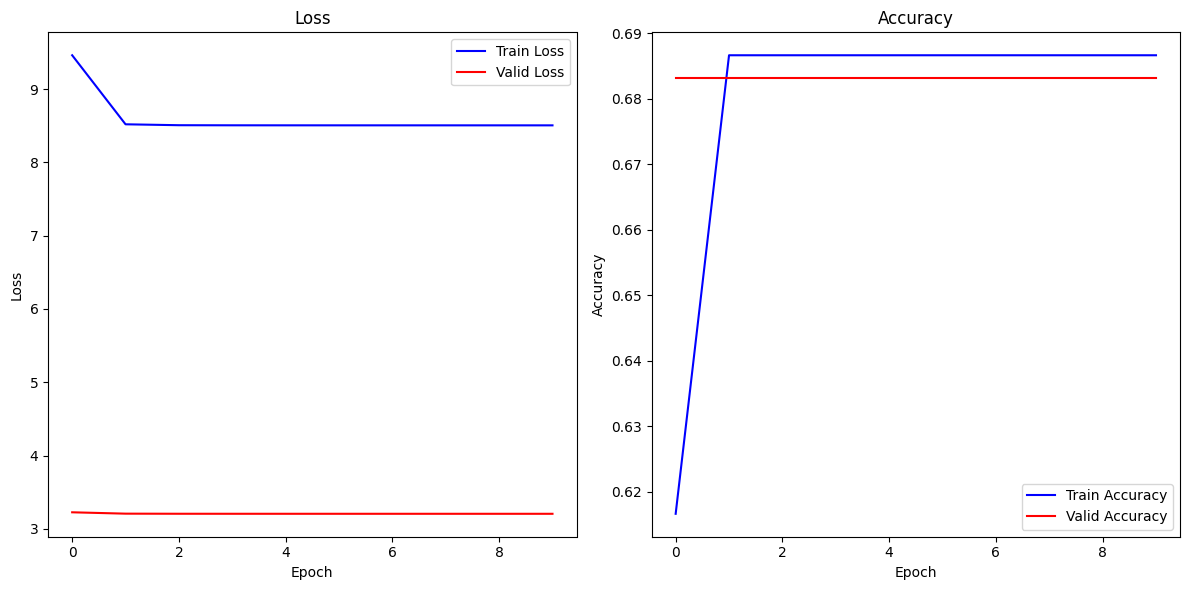

outputs_all shape 101 3
targets_all shape 101
Accuracy: 0.6832
Balanced Accuracy: 0.3333
F1: 0.5546
ROC AUC: 0.5508
Precision: 0.4667
Recall: 0.6832


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


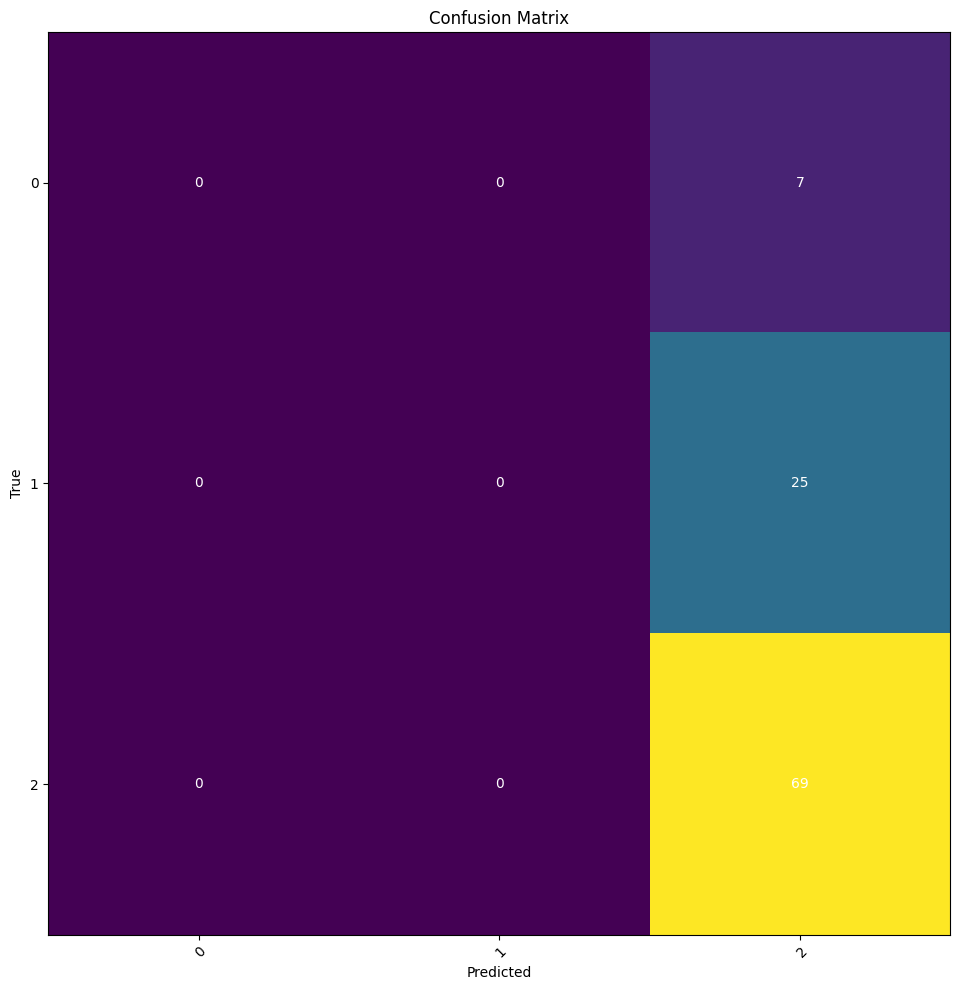

In [49]:
mini_gru_2layers_effectiveness_model, mini_gru_2layers_effectiveness_train_metrics = run_training(
    model_path="./models/gru_2layers_effectiveness_model.pth",
    model=GRU_2layers(input_size=1, hidden_size=32, output_size=DATALOADER_CONFIGS["effectiveness"]["num_encoded_labels"]),
    train_dataloader=mini_gru_2layers_effectiveness_train_dataloader,
    test_dataloader=mini_gru_2layers_effectiveness_test_dataloader,
    epochs=10,
    lr=0.01,
    save_model=True
)

plot_losses(mini_gru_2layers_effectiveness_train_metrics)

mini_gru_2layers_effectiveness_test_metrics = test_model(
    mini_gru_2layers_effectiveness_model,
    mini_gru_2layers_effectiveness_test_dataloader
)

plot_metrics(mini_gru_2layers_effectiveness_test_metrics)

Training ./models/gru_2layers_side_effects_model.pth model...
[1/10] | Train Loss: [10.1731] | Train Accuracy: [0.5467] | Valid Loss: [4.2980] | Valid Accuracy: [0.5446]
[2/10] | Train Loss: [10.0328] | Train Accuracy: [0.5467] | Valid Loss: [4.2794] | Valid Accuracy: [0.5446]
[3/10] | Train Loss: [10.0258] | Train Accuracy: [0.5467] | Valid Loss: [4.2797] | Valid Accuracy: [0.5446]
[4/10] | Train Loss: [10.0204] | Train Accuracy: [0.5467] | Valid Loss: [4.2804] | Valid Accuracy: [0.5446]
[5/10] | Train Loss: [10.0141] | Train Accuracy: [0.5467] | Valid Loss: [4.2790] | Valid Accuracy: [0.5446]
[6/10] | Train Loss: [10.0129] | Train Accuracy: [0.5467] | Valid Loss: [4.2789] | Valid Accuracy: [0.5446]
[7/10] | Train Loss: [9.9973] | Train Accuracy: [0.5467] | Valid Loss: [4.2704] | Valid Accuracy: [0.5446]
[8/10] | Train Loss: [10.0183] | Train Accuracy: [0.5467] | Valid Loss: [4.2837] | Valid Accuracy: [0.5446]
[9/10] | Train Loss: [10.0082] | Train Accuracy: [0.5467] | Valid Loss: [4.

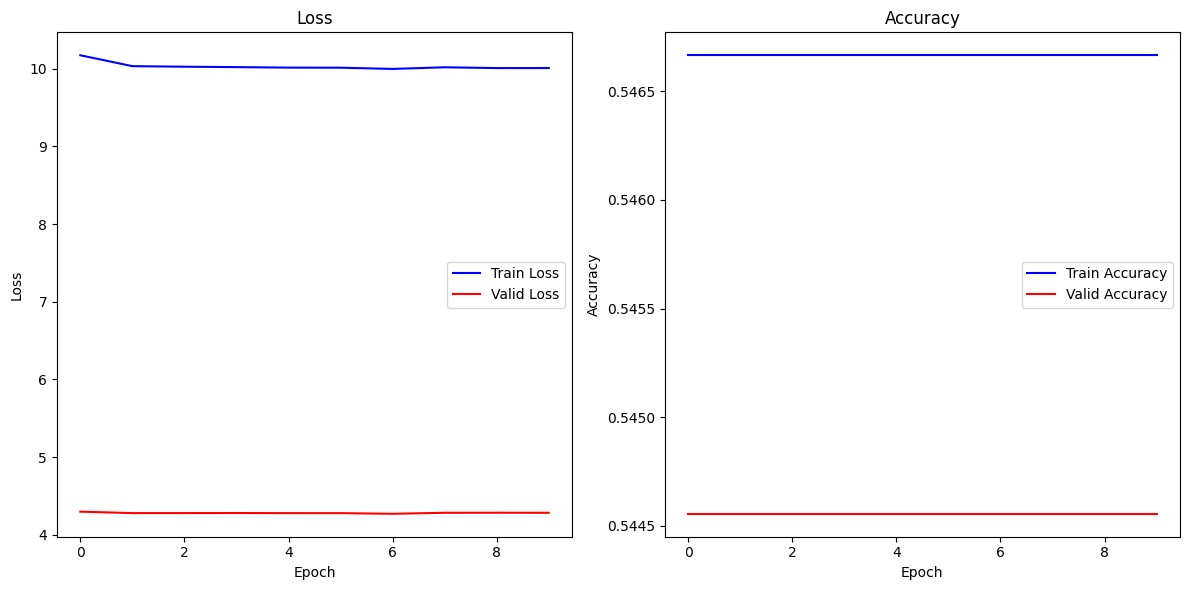

outputs_all shape 101 3
targets_all shape 101
Accuracy: 0.5446
Balanced Accuracy: 0.3333
F1: 0.3840
ROC AUC: 0.5382
Precision: 0.2965
Recall: 0.5446


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


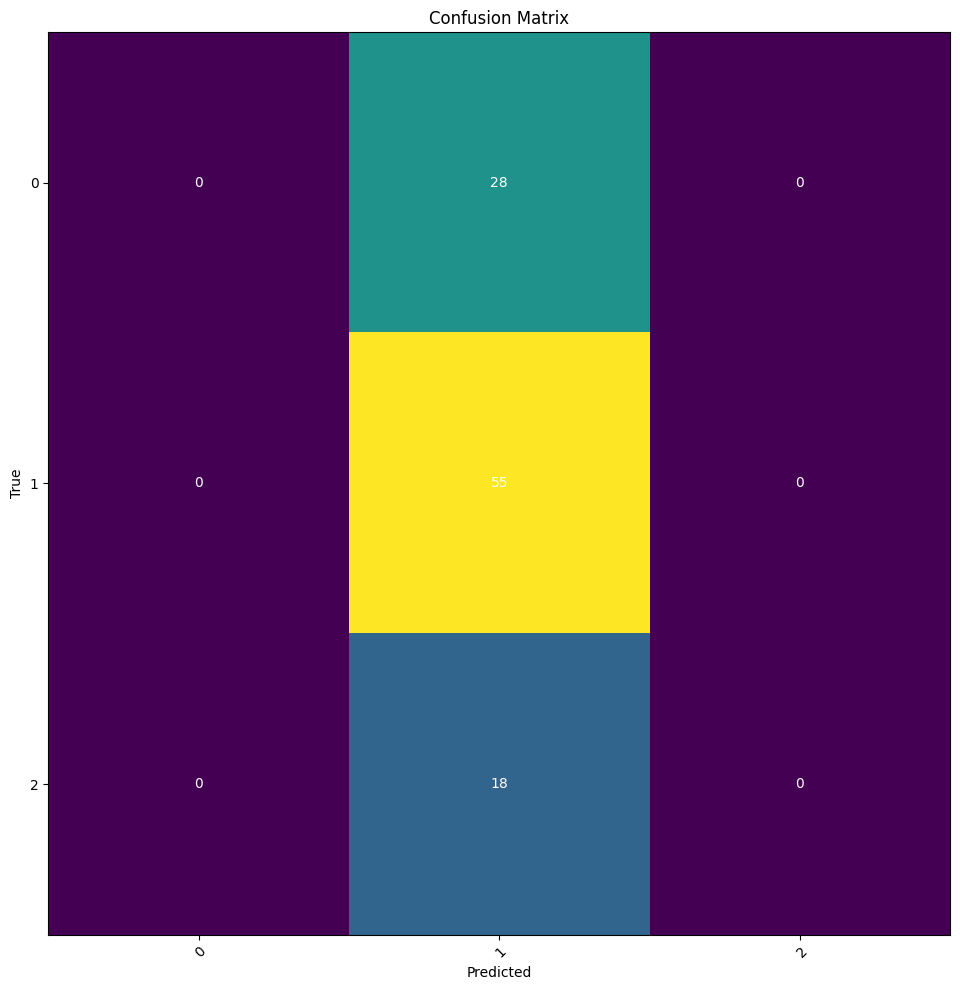

In [50]:
mini_gru_2layers_side_effects_model, mini_gru_2layers_side_effects_train_metrics = run_training(
    model_path="./models/gru_2layers_side_effects_model.pth",
    model=GRU_2layers(input_size=1, hidden_size=32, output_size=DATALOADER_CONFIGS["sideEffects"]["num_encoded_labels"]),
    train_dataloader=mini_gru_2layers_side_effects_train_dataloader,
    test_dataloader=mini_gru_2layers_side_effects_test_dataloader,
    epochs=10,
    lr=0.01,
    save_model=True
)

plot_losses(mini_gru_2layers_side_effects_train_metrics)

mini_gru_2layers_side_effects_test_metrics = test_model(
    mini_gru_2layers_side_effects_model,
    mini_gru_2layers_side_effects_test_dataloader
)

plot_metrics(mini_gru_2layers_side_effects_test_metrics)

### LSTM

In [51]:
BATCH_SIZE = 32
lstm_tokenizer = Tokenizer()
mini_lstm_rating_train_dataloader = create_dataloader(mini_rating_train_df, "commentsReview", "rating_encoded", lstm_tokenizer, batch_size=BATCH_SIZE)
mini_lstm_rating_test_dataloader = create_dataloader(mini_rating_test_df, "commentsReview", "rating_encoded", lstm_tokenizer, batch_size=BATCH_SIZE)
mini_lstm_effectiveness_train_dataloader = create_dataloader(mini_effectiveness_train_df, "commentsReview", "effectiveness_encoded", lstm_tokenizer, batch_size=BATCH_SIZE)
mini_lstm_effectiveness_test_dataloader = create_dataloader(mini_effectiveness_test_df, "commentsReview", "effectiveness_encoded", lstm_tokenizer, batch_size=BATCH_SIZE)
mini_lstm_side_effects_train_dataloader = create_dataloader(mini_side_effects_train_df, "commentsReview", "sideEffects_encoded", lstm_tokenizer, batch_size=BATCH_SIZE)
mini_lstm_side_effects_test_dataloader = create_dataloader(mini_side_effects_test_df, "commentsReview", "sideEffects_encoded", lstm_tokenizer, batch_size=BATCH_SIZE)

Training ./models/lstm_rating_model.pth model...
[1/10] | Train Loss: [11.0224] | Train Accuracy: [0.2400] | Valid Loss: [4.4065] | Valid Accuracy: [0.2376]
[2/10] | Train Loss: [10.9995] | Train Accuracy: [0.2400] | Valid Loss: [4.3955] | Valid Accuracy: [0.2376]
[3/10] | Train Loss: [10.9769] | Train Accuracy: [0.2400] | Valid Loss: [4.3845] | Valid Accuracy: [0.2376]
[4/10] | Train Loss: [10.9543] | Train Accuracy: [0.5167] | Valid Loss: [4.3734] | Valid Accuracy: [0.6238]
[5/10] | Train Loss: [10.9318] | Train Accuracy: [0.6233] | Valid Loss: [4.3624] | Valid Accuracy: [0.6238]
[6/10] | Train Loss: [10.9090] | Train Accuracy: [0.6233] | Valid Loss: [4.3512] | Valid Accuracy: [0.6238]
[7/10] | Train Loss: [10.8861] | Train Accuracy: [0.6233] | Valid Loss: [4.3398] | Valid Accuracy: [0.6238]
[8/10] | Train Loss: [10.8628] | Train Accuracy: [0.6233] | Valid Loss: [4.3282] | Valid Accuracy: [0.6238]
[9/10] | Train Loss: [10.8390] | Train Accuracy: [0.6233] | Valid Loss: [4.3164] | Vali

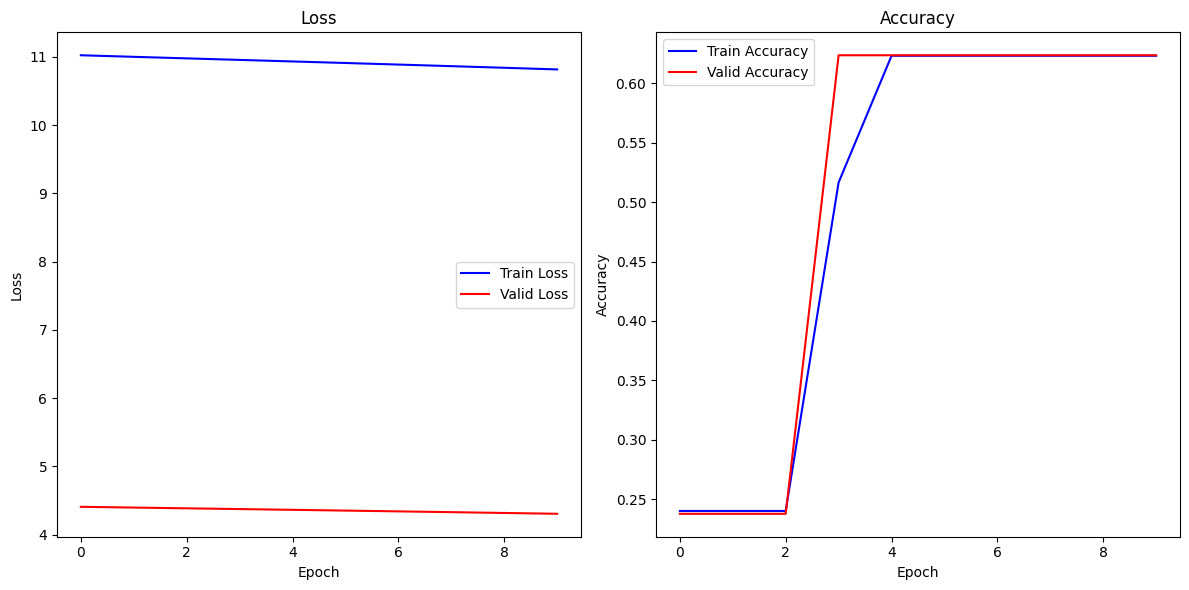

outputs_all shape 101 3
targets_all shape 101
Accuracy: 0.6238
Balanced Accuracy: 0.3333
F1: 0.4792
ROC AUC: 0.5000
Precision: 0.3891
Recall: 0.6238


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


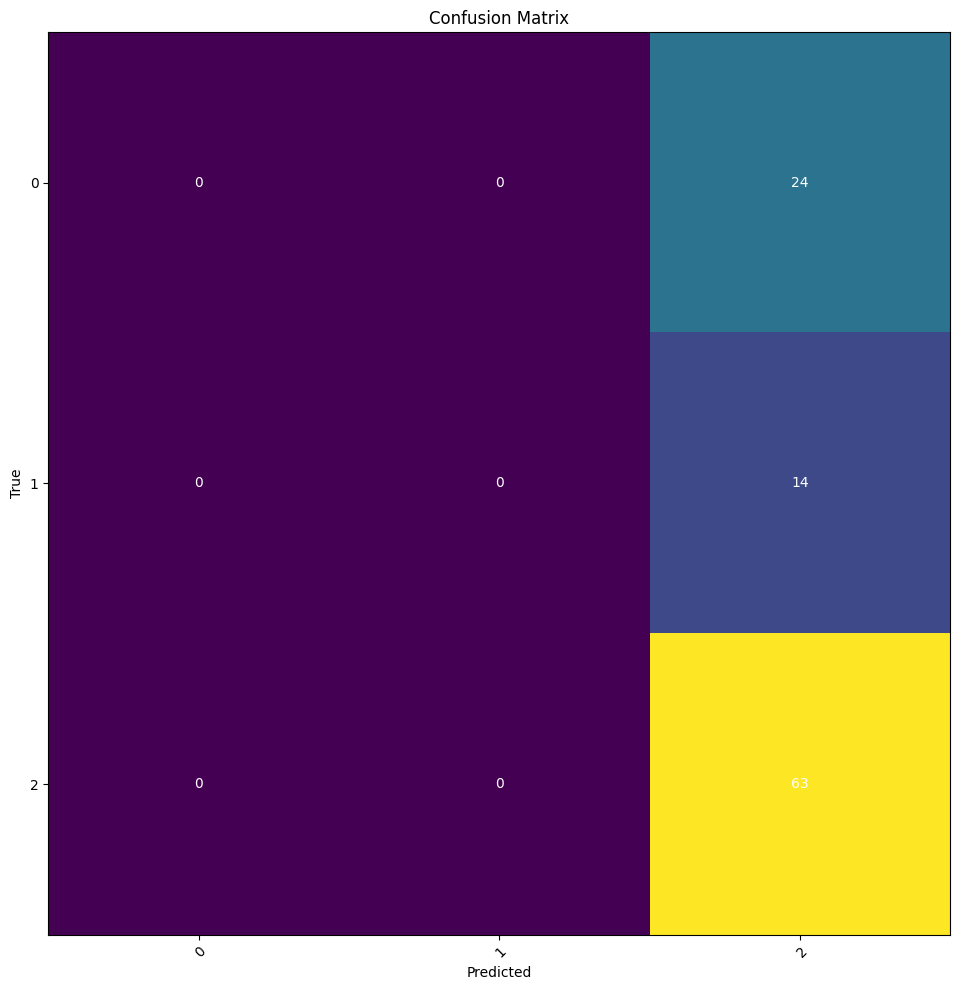

In [53]:
lstm_rating_model, lstm_rating_train_metrics = run_training(
    model_path="./models/lstm_rating_model.pth",
    model=LSTM(input_size=1, hidden_size=32, output_size=DATALOADER_CONFIGS["rating"]["num_encoded_labels"]),
    train_dataloader=mini_lstm_rating_train_dataloader,
    test_dataloader=mini_lstm_rating_test_dataloader,
    epochs=10,
    lr=0.0001,
    save_model=True
)

plot_losses(lstm_rating_train_metrics)

lstm_rating_test_metrics = test_model(
    lstm_rating_model,
    mini_lstm_rating_test_dataloader
)

plot_metrics(lstm_rating_test_metrics)

Training ./models/lstm_effectiveness_model.pth model...
[1/10] | Train Loss: [11.0396] | Train Accuracy: [0.1667] | Valid Loss: [4.3282] | Valid Accuracy: [0.6832]
[2/10] | Train Loss: [10.6827] | Train Accuracy: [0.6867] | Valid Loss: [4.1577] | Valid Accuracy: [0.6832]
[3/10] | Train Loss: [10.2705] | Train Accuracy: [0.6867] | Valid Loss: [3.9454] | Valid Accuracy: [0.6832]
[4/10] | Train Loss: [9.7494] | Train Accuracy: [0.6867] | Valid Loss: [3.6737] | Valid Accuracy: [0.6832]
[5/10] | Train Loss: [9.1677] | Train Accuracy: [0.6867] | Valid Loss: [3.4217] | Valid Accuracy: [0.6832]
[6/10] | Train Loss: [8.7874] | Train Accuracy: [0.6867] | Valid Loss: [3.3053] | Valid Accuracy: [0.6832]
[7/10] | Train Loss: [8.6430] | Train Accuracy: [0.6867] | Valid Loss: [3.2634] | Valid Accuracy: [0.6832]
[8/10] | Train Loss: [8.5900] | Train Accuracy: [0.6867] | Valid Loss: [3.2456] | Valid Accuracy: [0.6832]
[9/10] | Train Loss: [8.5661] | Train Accuracy: [0.6867] | Valid Loss: [3.2364] | Val

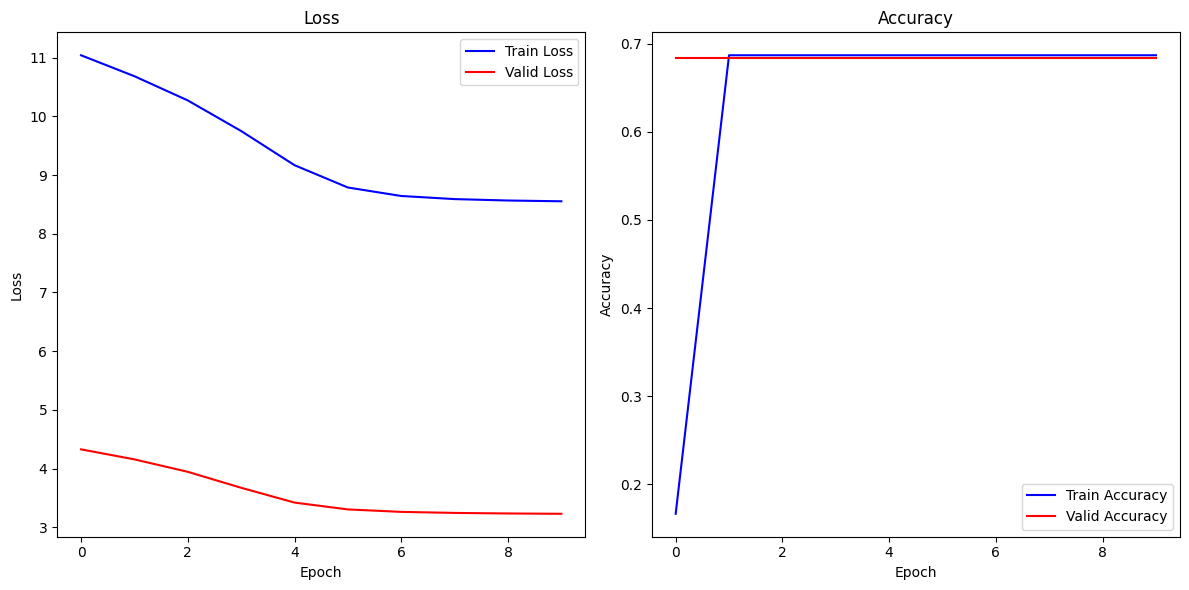

outputs_all shape 101 3
targets_all shape 101
Accuracy: 0.6832
Balanced Accuracy: 0.3333
F1: 0.5546
ROC AUC: 0.5000
Precision: 0.4667
Recall: 0.6832


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


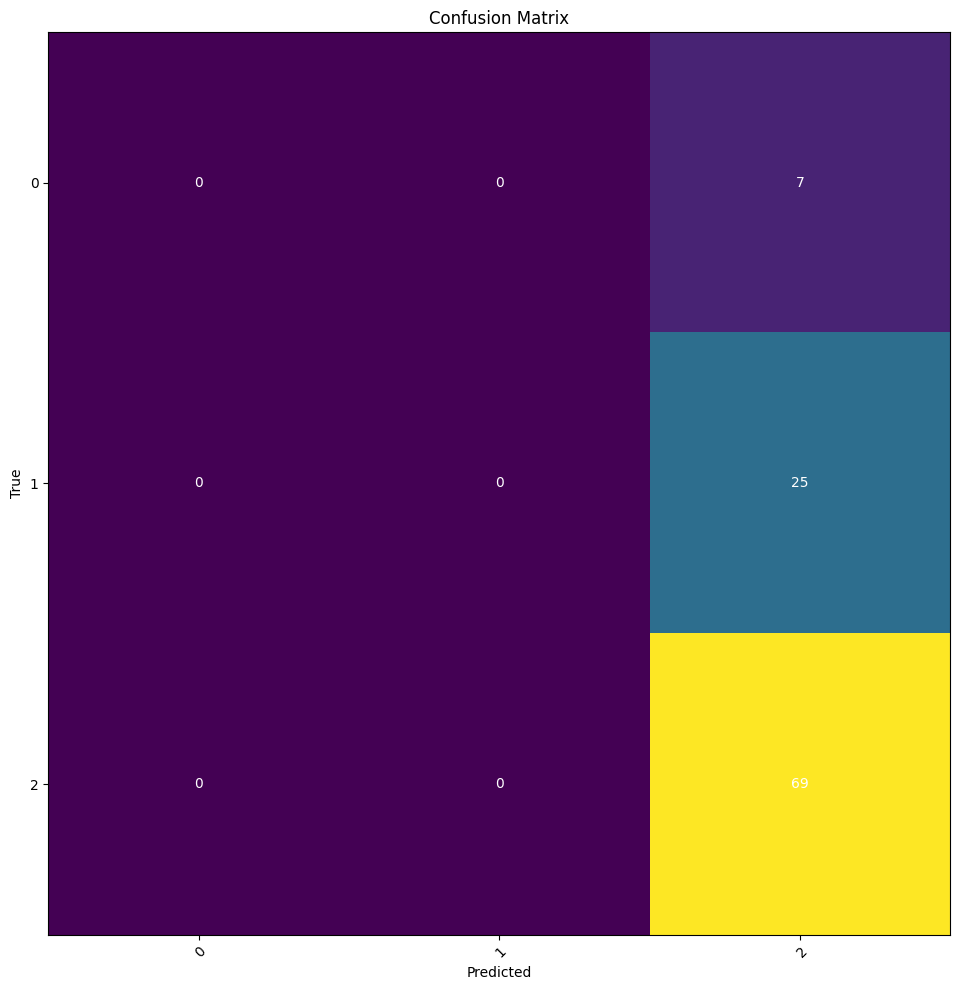

In [55]:
lstm_effectiveness_model, lstm_effectiveness_train_metrics = run_training(
    model_path="./models/lstm_effectiveness_model.pth",
    model=LSTM(input_size=1, hidden_size=32, output_size=DATALOADER_CONFIGS["effectiveness"]["num_encoded_labels"]),
    train_dataloader=mini_lstm_effectiveness_train_dataloader,
    test_dataloader=mini_lstm_effectiveness_test_dataloader,
    epochs=10,
    lr=0.001,
    save_model=True
)

plot_losses(lstm_effectiveness_train_metrics)

lstm_effectiveness_test_metrics = test_model(
    lstm_effectiveness_model,
    mini_lstm_effectiveness_test_dataloader
)

plot_metrics(lstm_effectiveness_test_metrics)


Training ./models/lstm_side_effects_model.pth model...
[1/10] | Train Loss: [11.1878] | Train Accuracy: [0.1767] | Valid Loss: [4.4055] | Valid Accuracy: [0.1782]
[2/10] | Train Loss: [11.0324] | Train Accuracy: [0.1867] | Valid Loss: [4.3698] | Valid Accuracy: [0.5446]
[3/10] | Train Loss: [10.8719] | Train Accuracy: [0.5467] | Valid Loss: [4.3308] | Valid Accuracy: [0.5446]
[4/10] | Train Loss: [10.6855] | Train Accuracy: [0.5467] | Valid Loss: [4.2864] | Valid Accuracy: [0.5446]
[5/10] | Train Loss: [10.4485] | Train Accuracy: [0.5467] | Valid Loss: [4.2425] | Valid Accuracy: [0.5446]
[6/10] | Train Loss: [10.1922] | Train Accuracy: [0.5467] | Valid Loss: [4.2394] | Valid Accuracy: [0.5446]
[7/10] | Train Loss: [10.0719] | Train Accuracy: [0.5467] | Valid Loss: [4.2615] | Valid Accuracy: [0.5446]
[8/10] | Train Loss: [10.0514] | Train Accuracy: [0.5467] | Valid Loss: [4.2717] | Valid Accuracy: [0.5446]
[9/10] | Train Loss: [10.0473] | Train Accuracy: [0.5467] | Valid Loss: [4.2749] 

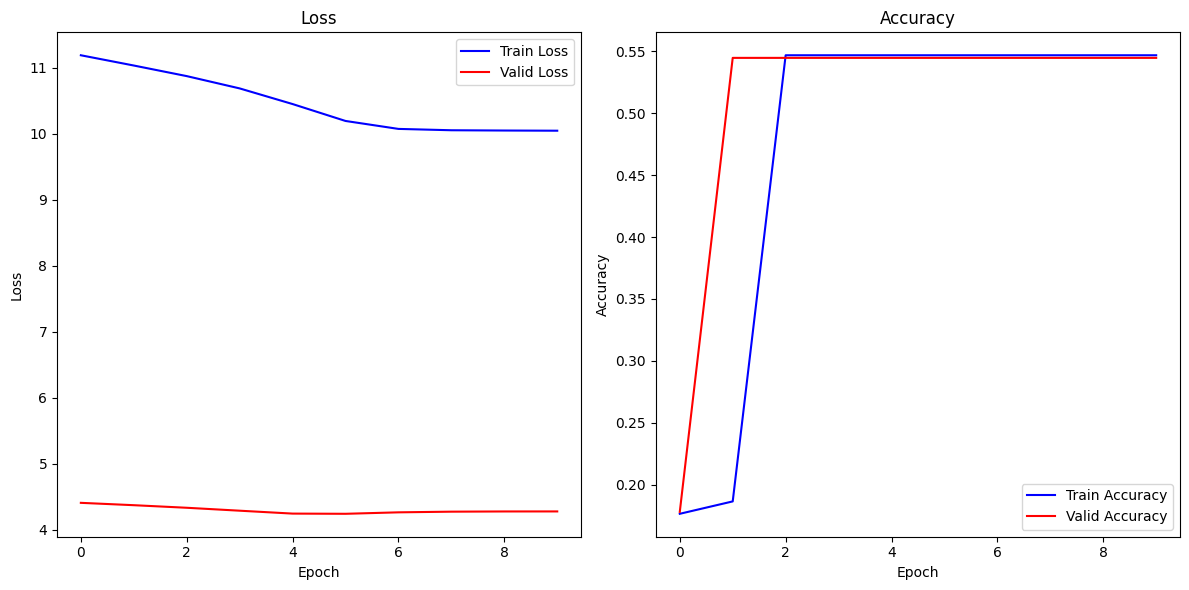

outputs_all shape 101 3
targets_all shape 101
Accuracy: 0.5446
Balanced Accuracy: 0.3333
F1: 0.3840
ROC AUC: 0.5012
Precision: 0.2965
Recall: 0.5446


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


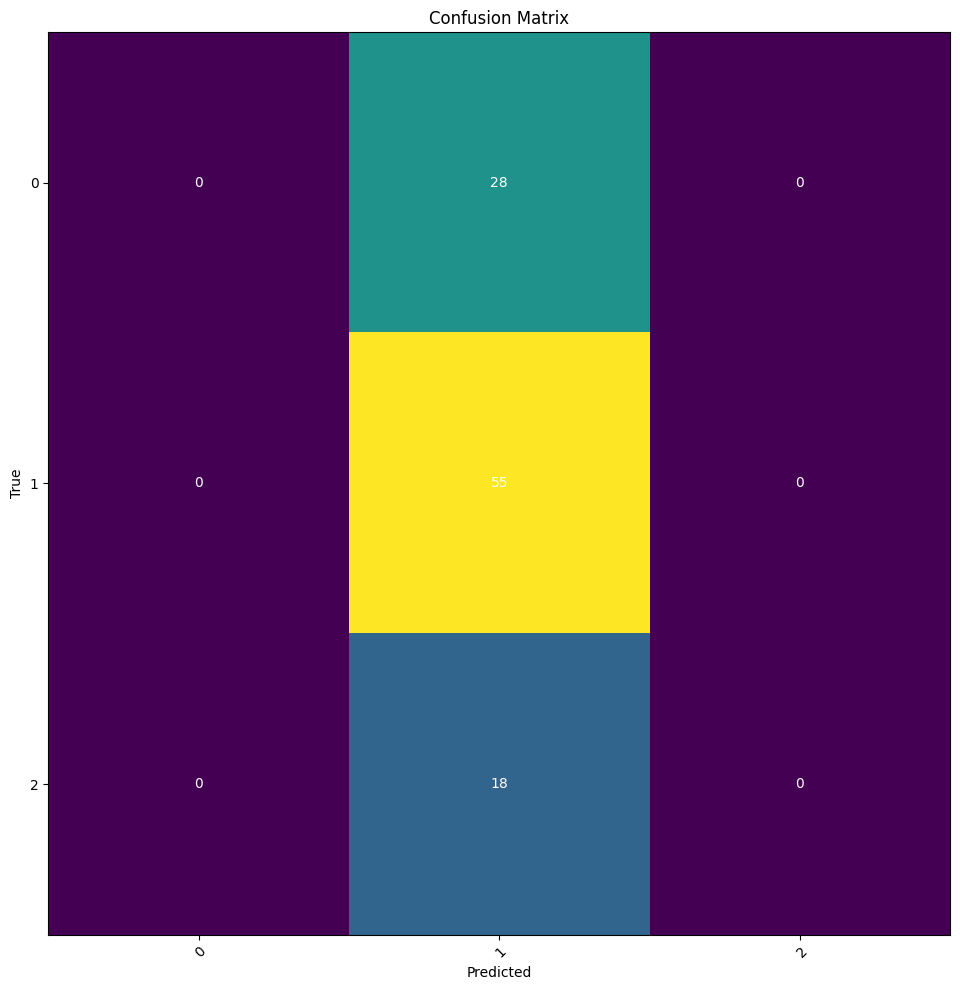

In [56]:
lstm_side_effects_model, lstm_side_effects_train_metrics = run_training(
    model_path="./models/lstm_side_effects_model.pth",
    model=LSTM(input_size=1, hidden_size=32, output_size=DATALOADER_CONFIGS["sideEffects"]["num_encoded_labels"]),
    train_dataloader=mini_lstm_side_effects_train_dataloader,
    test_dataloader=mini_lstm_side_effects_test_dataloader,
    epochs=10,
    lr=0.001,
    save_model=True
)

plot_losses(lstm_side_effects_train_metrics)

lstm_side_effects_test_metrics = test_model(
    lstm_side_effects_model,
    mini_lstm_side_effects_test_dataloader
)

plot_metrics(lstm_side_effects_test_metrics)


### GPT

In [57]:
BATCH_SIZE = 32
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
mini_gpt2_rating_train_dataloader = create_dataloader(mini_rating_train_df, "commentsReview", "rating_encoded", gpt2_tokenizer, batch_size=BATCH_SIZE)
mini_gpt2_rating_test_dataloader = create_dataloader(mini_rating_test_df, "commentsReview", "rating_encoded", gpt2_tokenizer, batch_size=BATCH_SIZE)
mini_gpt2_effectiveness_train_dataloader = create_dataloader(mini_effectiveness_train_df, "commentsReview", "effectiveness_encoded", gpt2_tokenizer, batch_size=BATCH_SIZE)
mini_gpt2_effectiveness_test_dataloader = create_dataloader(mini_effectiveness_test_df, "commentsReview", "effectiveness_encoded", gpt2_tokenizer, batch_size=BATCH_SIZE)
mini_gpt2_side_effects_train_dataloader = create_dataloader(mini_side_effects_train_df, "commentsReview", "sideEffects_encoded", gpt2_tokenizer, batch_size=BATCH_SIZE)
mini_gpt2_side_effects_test_dataloader = create_dataloader(mini_side_effects_test_df, "commentsReview", "sideEffects_encoded", gpt2_tokenizer, batch_size=BATCH_SIZE)

Training ./models/gpt2_rating_model.pth model...
[1/5] | Train Loss: [10.2079] | Train Accuracy: [0.4667] | Valid Loss: [3.4009] | Valid Accuracy: [0.6238]
[2/5] | Train Loss: [9.1516] | Train Accuracy: [0.6233] | Valid Loss: [3.3944] | Valid Accuracy: [0.6238]
[3/5] | Train Loss: [9.1488] | Train Accuracy: [0.6233] | Valid Loss: [3.3939] | Valid Accuracy: [0.6238]
[4/5] | Train Loss: [9.1500] | Train Accuracy: [0.6233] | Valid Loss: [3.3939] | Valid Accuracy: [0.6238]
[5/5] | Train Loss: [9.1476] | Train Accuracy: [0.6233] | Valid Loss: [3.3938] | Valid Accuracy: [0.6238]


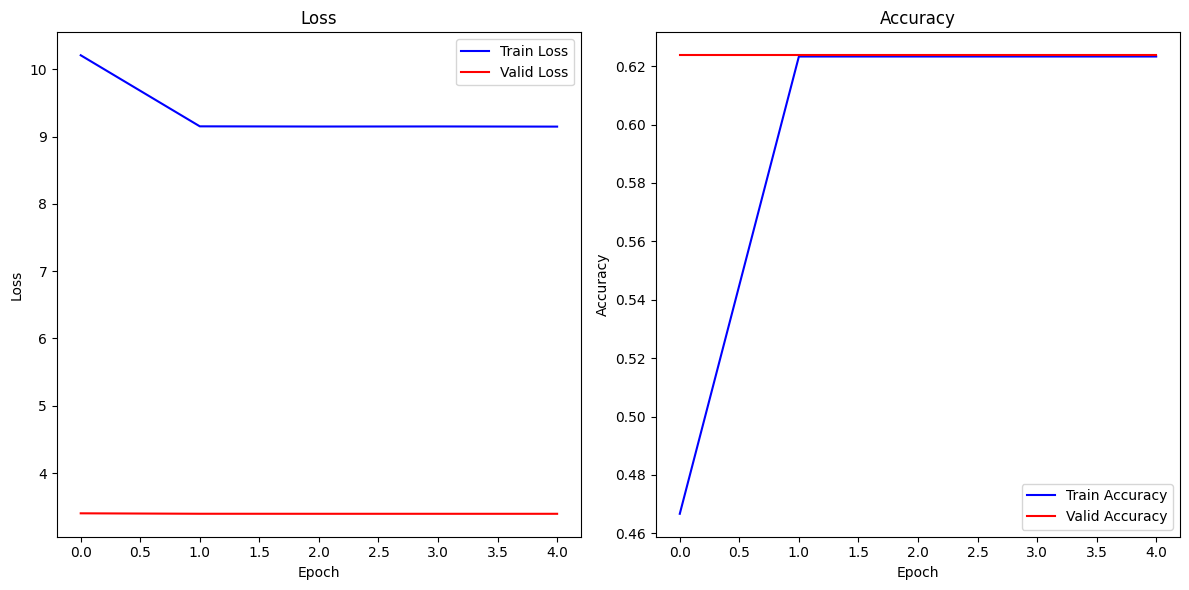

outputs_all shape 101 3
targets_all shape 101
Accuracy: 0.6238
Balanced Accuracy: 0.3333
F1: 0.4792
ROC AUC: 0.4987
Precision: 0.3891
Recall: 0.6238


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


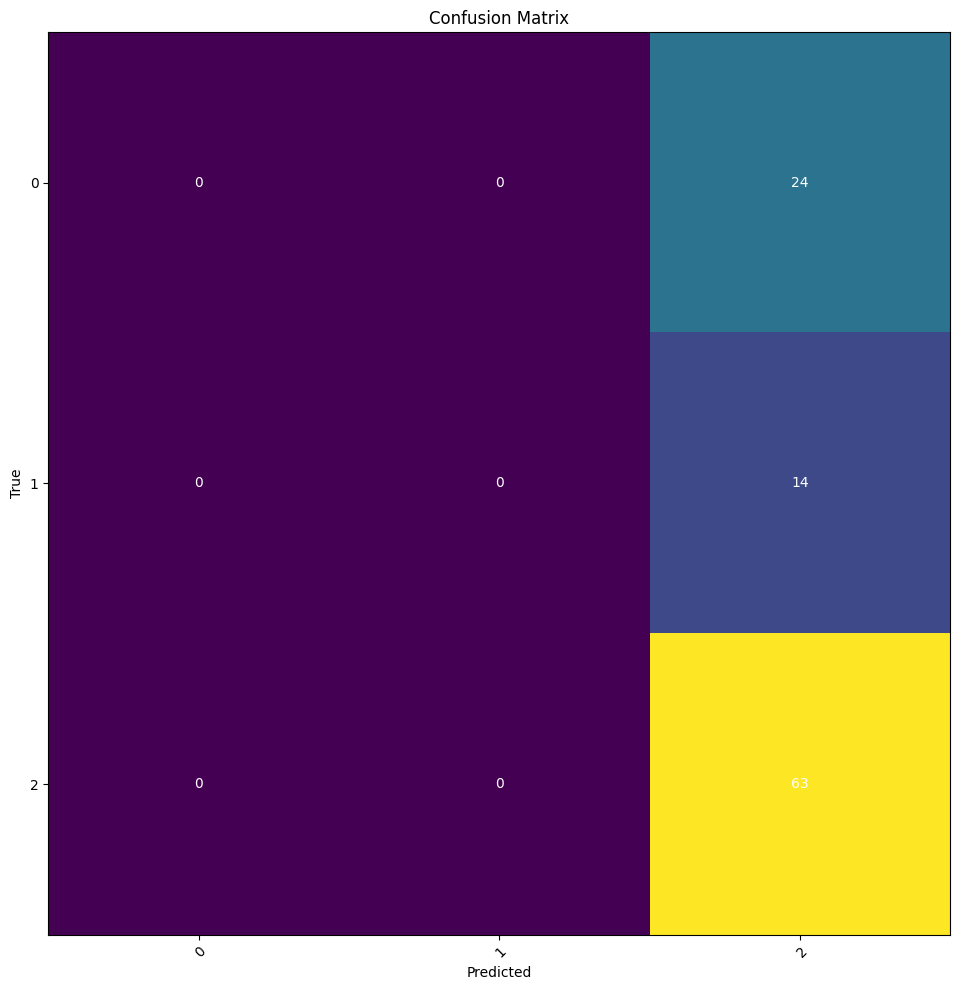

In [58]:
gpt2_rating_model, gpt2_rating_train_metrics = run_training(
    model_path="./models/gpt2_rating_model.pth",
    model=GPT2Classification(n_classes=DATALOADER_CONFIGS["rating"]["num_encoded_labels"]),
    train_dataloader=mini_gpt2_rating_train_dataloader,
    test_dataloader=mini_gpt2_rating_test_dataloader,
    epochs=5,
    lr=0.001,
    save_model=True
)

plot_losses(gpt2_rating_train_metrics)

gpt2_rating_test_metrics = test_model(
    gpt2_rating_model,
    mini_gpt2_rating_test_dataloader
)

plot_metrics(gpt2_rating_test_metrics)

Training ./models/gpt2_effectiveness_model.pth model...
[1/5] | Train Loss: [9.3730] | Train Accuracy: [0.5900] | Valid Loss: [3.2109] | Valid Accuracy: [0.6832]
[2/5] | Train Loss: [8.5034] | Train Accuracy: [0.6867] | Valid Loss: [3.2068] | Valid Accuracy: [0.6832]
[3/5] | Train Loss: [8.5042] | Train Accuracy: [0.6867] | Valid Loss: [3.2064] | Valid Accuracy: [0.6832]
[4/5] | Train Loss: [8.5002] | Train Accuracy: [0.6867] | Valid Loss: [3.2064] | Valid Accuracy: [0.6832]
[5/5] | Train Loss: [8.4985] | Train Accuracy: [0.6867] | Valid Loss: [3.2065] | Valid Accuracy: [0.6832]


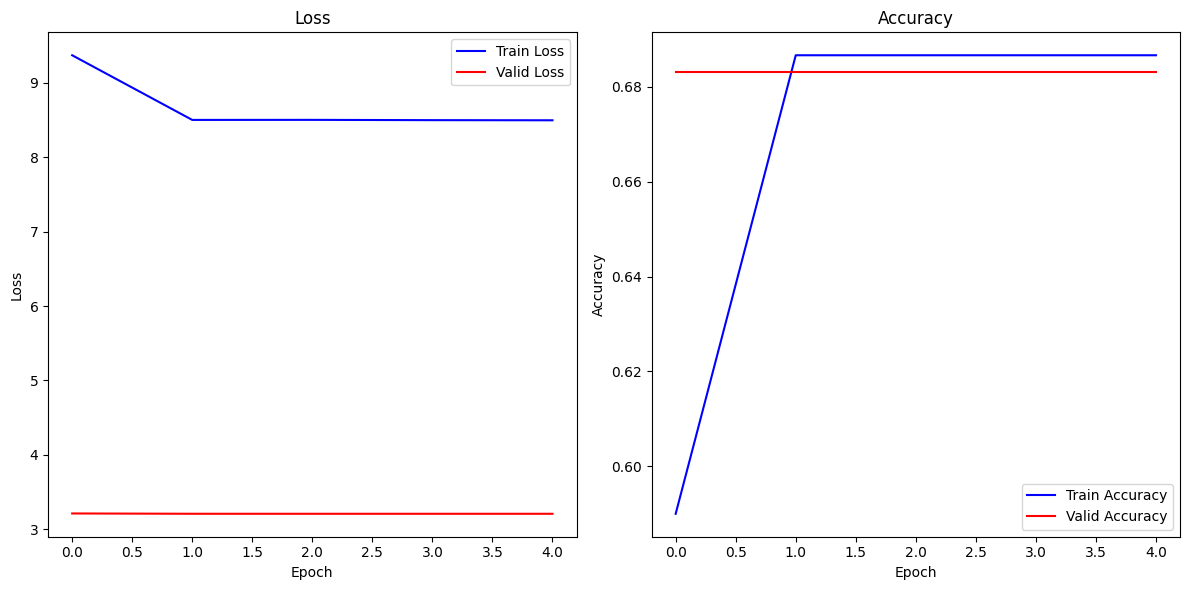

outputs_all shape 101 3
targets_all shape 101
Accuracy: 0.6832
Balanced Accuracy: 0.3333
F1: 0.5546
ROC AUC: 0.4544
Precision: 0.4667
Recall: 0.6832


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


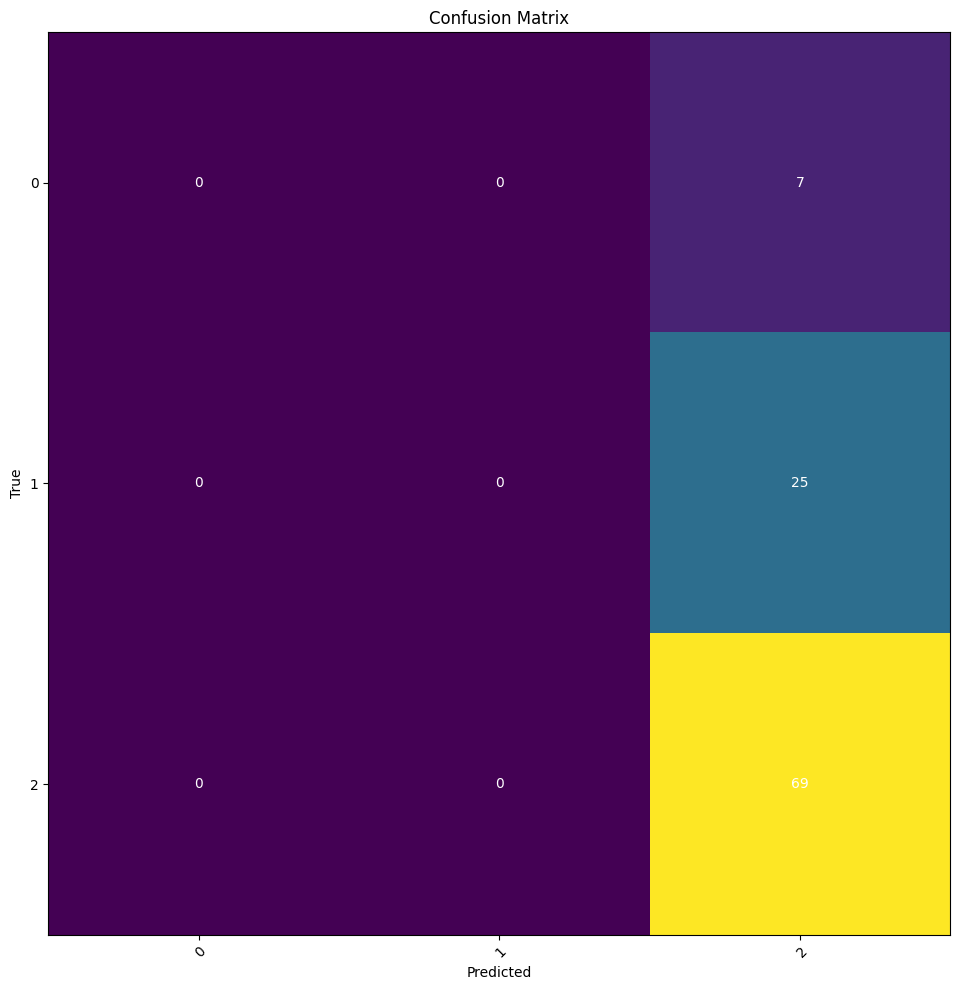

In [59]:
gpt2_effectiveness_model, gpt2_effectiveness_train_metrics = run_training(
    model_path="./models/gpt2_effectiveness_model.pth",
    model=GPT2Classification(n_classes=DATALOADER_CONFIGS["effectiveness"]["num_encoded_labels"]),
    train_dataloader=mini_gpt2_effectiveness_train_dataloader,
    test_dataloader=mini_gpt2_effectiveness_test_dataloader,
    epochs=5,
    lr=0.001,
    save_model=True
)

plot_losses(gpt2_effectiveness_train_metrics)

gpt2_effectiveness_test_metrics = test_model(
    gpt2_effectiveness_model,
    mini_gpt2_effectiveness_test_dataloader
)

plot_metrics(gpt2_effectiveness_test_metrics)

Training ./models/gpt2_side_effects_model.pth model...
[1/5] | Train Loss: [10.1595] | Train Accuracy: [0.5433] | Valid Loss: [4.3152] | Valid Accuracy: [0.5446]
[2/5] | Train Loss: [10.0699] | Train Accuracy: [0.5467] | Valid Loss: [4.3171] | Valid Accuracy: [0.5446]
[3/5] | Train Loss: [10.0662] | Train Accuracy: [0.5467] | Valid Loss: [4.3170] | Valid Accuracy: [0.5446]
[4/5] | Train Loss: [10.0642] | Train Accuracy: [0.5467] | Valid Loss: [4.3159] | Valid Accuracy: [0.5446]
[5/5] | Train Loss: [10.0463] | Train Accuracy: [0.5467] | Valid Loss: [4.3095] | Valid Accuracy: [0.5446]


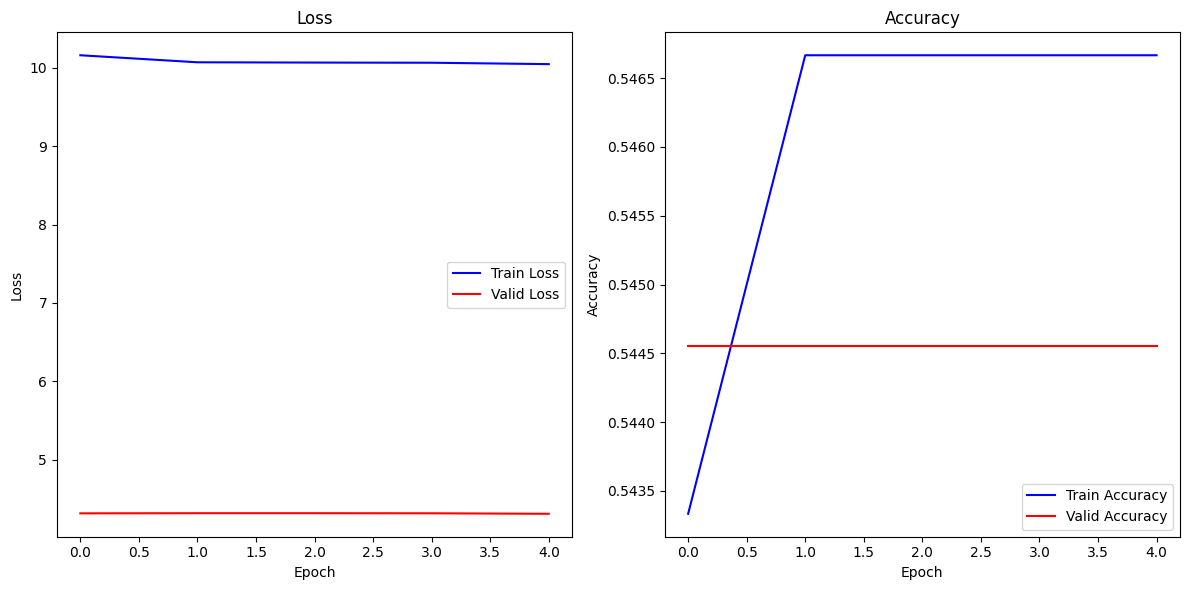

outputs_all shape 101 3
targets_all shape 101
Accuracy: 0.5446
Balanced Accuracy: 0.3333
F1: 0.3840
ROC AUC: 0.5291
Precision: 0.2965
Recall: 0.5446


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


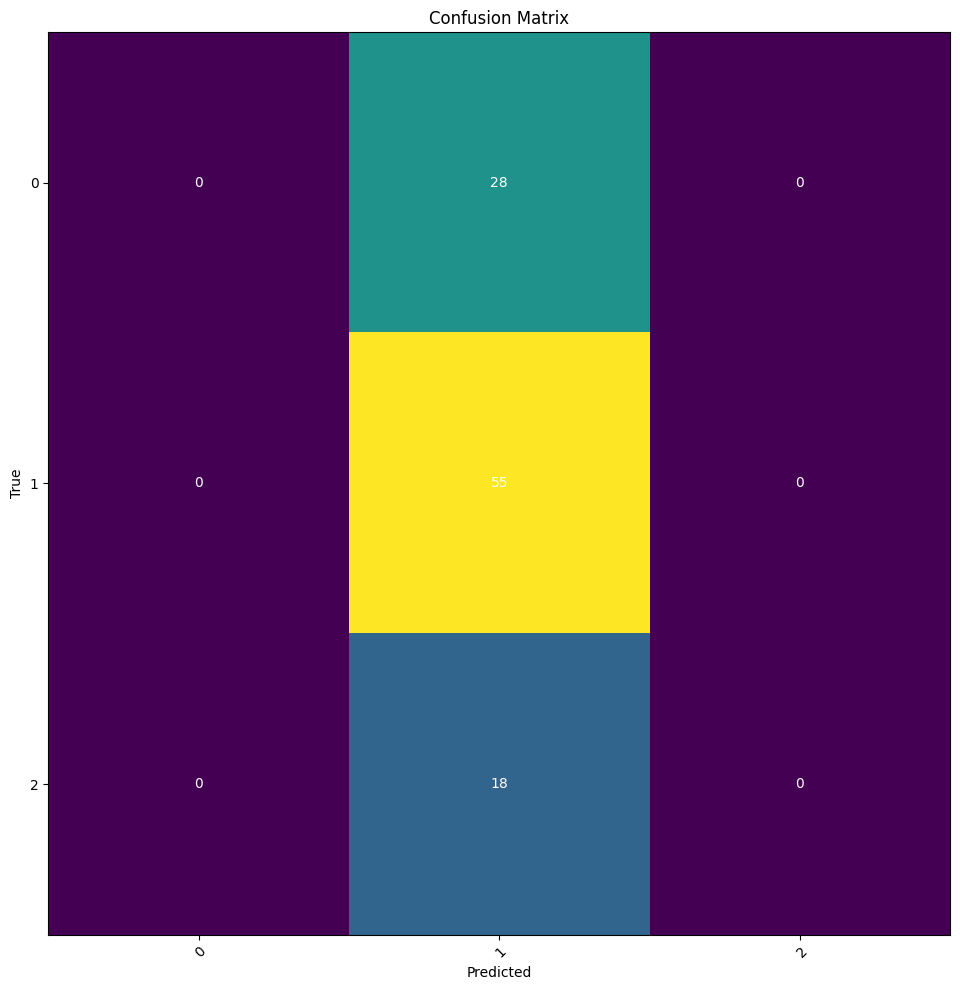

In [60]:
gpt2_side_effects_model, gpt2_side_effects_train_metrics = run_training(
    model_path="./models/gpt2_side_effects_model.pth",
    model=GPT2Classification(n_classes=DATALOADER_CONFIGS["sideEffects"]["num_encoded_labels"]),
    train_dataloader=mini_gpt2_side_effects_train_dataloader,
    test_dataloader=mini_gpt2_side_effects_test_dataloader,
    epochs=5,
    lr=0.001,
    save_model=True
)

plot_losses(gpt2_side_effects_train_metrics)

gpt2_side_effects_test_metrics = test_model(
    gpt2_side_effects_model,
    mini_gpt2_side_effects_test_dataloader
)

plot_metrics(gpt2_side_effects_test_metrics)

### BERT

In [61]:
BATCH_SIZE = 32
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mini_bert_rating_train_dataloader = create_dataloader(mini_rating_train_df, "commentsReview", "rating_encoded", bert_tokenizer, batch_size=BATCH_SIZE)
mini_bert_rating_test_dataloader = create_dataloader(mini_rating_test_df, "commentsReview", "rating_encoded", bert_tokenizer, batch_size=BATCH_SIZE)
mini_bert_effectiveness_train_dataloader = create_dataloader(mini_effectiveness_train_df, "commentsReview", "effectiveness_encoded", bert_tokenizer, batch_size=BATCH_SIZE)
mini_bert_effectiveness_test_dataloader = create_dataloader(mini_effectiveness_test_df, "commentsReview", "effectiveness_encoded", bert_tokenizer, batch_size=BATCH_SIZE)
mini_bert_side_effects_train_dataloader = create_dataloader(mini_side_effects_train_df, "commentsReview", "sideEffects_encoded", bert_tokenizer, batch_size=BATCH_SIZE)
mini_bert_side_effects_test_dataloader = create_dataloader(mini_side_effects_test_df, "commentsReview", "sideEffects_encoded", bert_tokenizer, batch_size=BATCH_SIZE)


Training ./models/bert_rating_model.pth model...
[1/5] | Train Loss: [9.6094] | Train Accuracy: [0.5900] | Valid Loss: [3.3939] | Valid Accuracy: [0.6238]
[2/5] | Train Loss: [9.1508] | Train Accuracy: [0.6233] | Valid Loss: [3.3933] | Valid Accuracy: [0.6238]
[3/5] | Train Loss: [9.1500] | Train Accuracy: [0.6233] | Valid Loss: [3.3933] | Valid Accuracy: [0.6238]
[4/5] | Train Loss: [9.1499] | Train Accuracy: [0.6233] | Valid Loss: [3.3933] | Valid Accuracy: [0.6238]
[5/5] | Train Loss: [9.1499] | Train Accuracy: [0.6233] | Valid Loss: [3.3933] | Valid Accuracy: [0.6238]


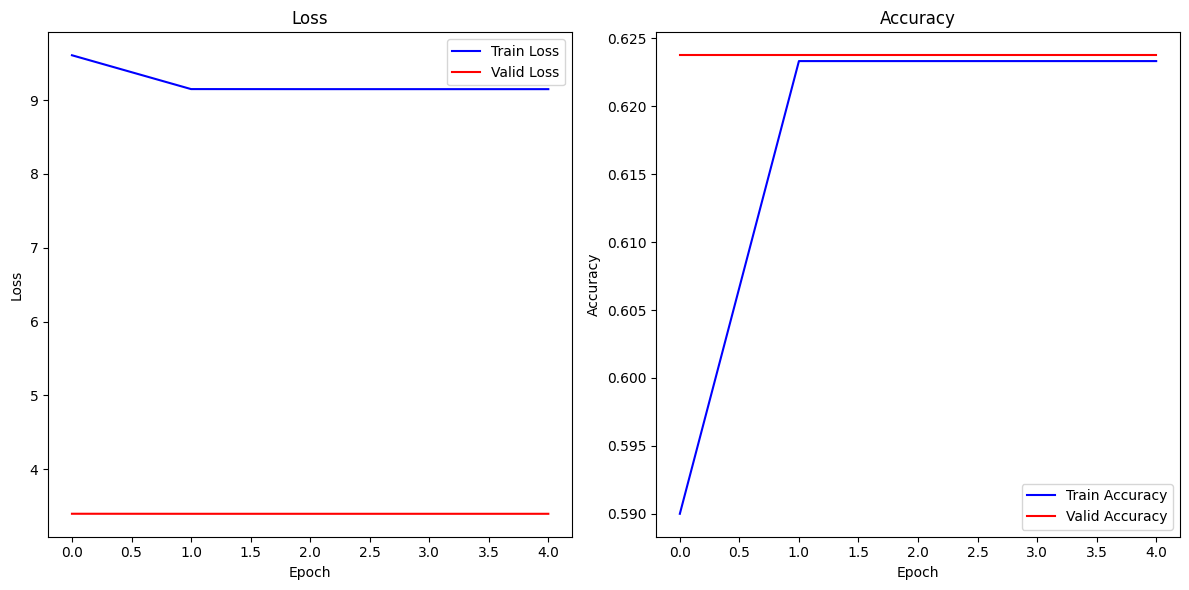

outputs_all shape 101 3
targets_all shape 101
Accuracy: 0.6238
Balanced Accuracy: 0.3333
F1: 0.4792
ROC AUC: 0.5050
Precision: 0.3891
Recall: 0.6238


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


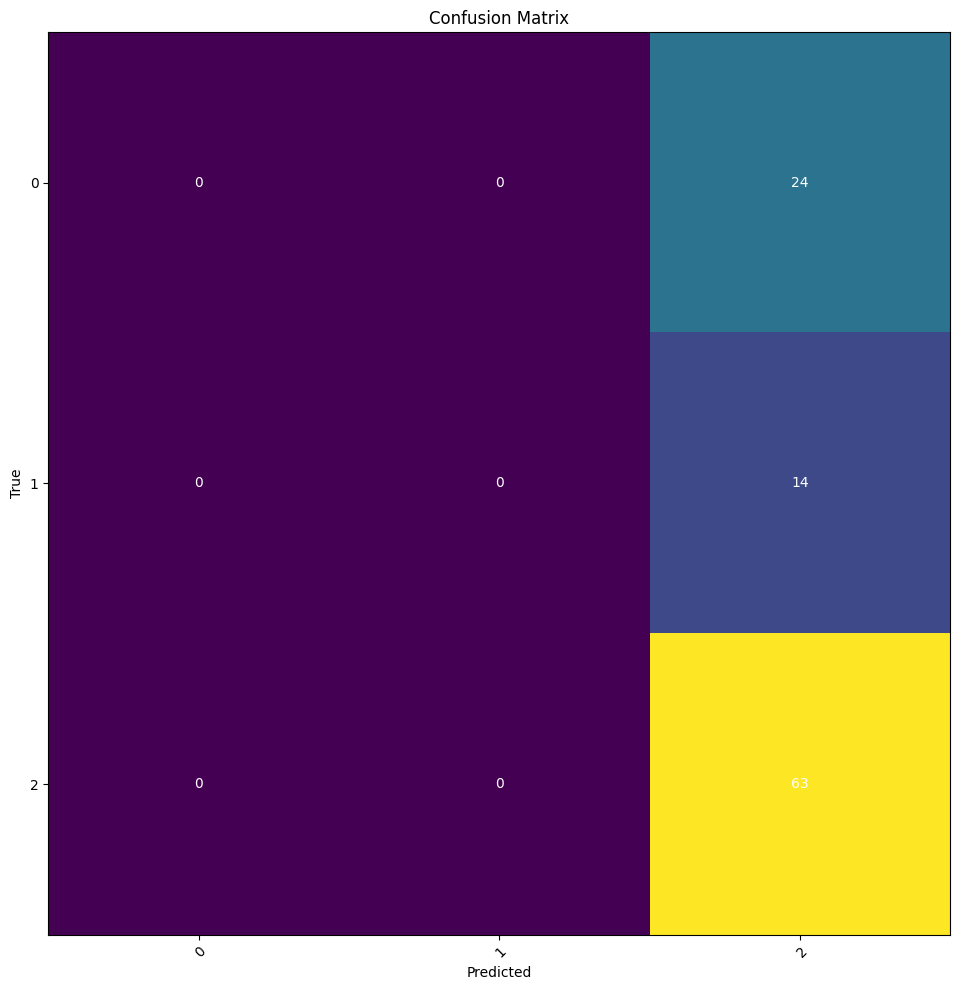

In [62]:

bert_rating_model, bert_rating_train_metrics = run_training(
    model_path="./models/bert_rating_model.pth",
    model=BERTClassification(n_classes=DATALOADER_CONFIGS["rating"]["num_encoded_labels"]),
    train_dataloader=mini_bert_rating_train_dataloader,
    test_dataloader=mini_bert_rating_test_dataloader,
    epochs=5,
    lr=0.001,
    save_model=True
)

plot_losses(bert_rating_train_metrics)

bert_rating_test_metrics = test_model(
    bert_rating_model,
    mini_bert_rating_test_dataloader
)

plot_metrics(bert_rating_test_metrics)


Training ./models/bert_effectiveness_model.pth model...
[1/5] | Train Loss: [9.2250] | Train Accuracy: [0.6133] | Valid Loss: [3.2067] | Valid Accuracy: [0.6832]
[2/5] | Train Loss: [8.5054] | Train Accuracy: [0.6867] | Valid Loss: [3.2058] | Valid Accuracy: [0.6832]
[3/5] | Train Loss: [8.5042] | Train Accuracy: [0.6867] | Valid Loss: [3.2058] | Valid Accuracy: [0.6832]
[4/5] | Train Loss: [8.5041] | Train Accuracy: [0.6867] | Valid Loss: [3.2058] | Valid Accuracy: [0.6832]
[5/5] | Train Loss: [8.5041] | Train Accuracy: [0.6867] | Valid Loss: [3.2058] | Valid Accuracy: [0.6832]


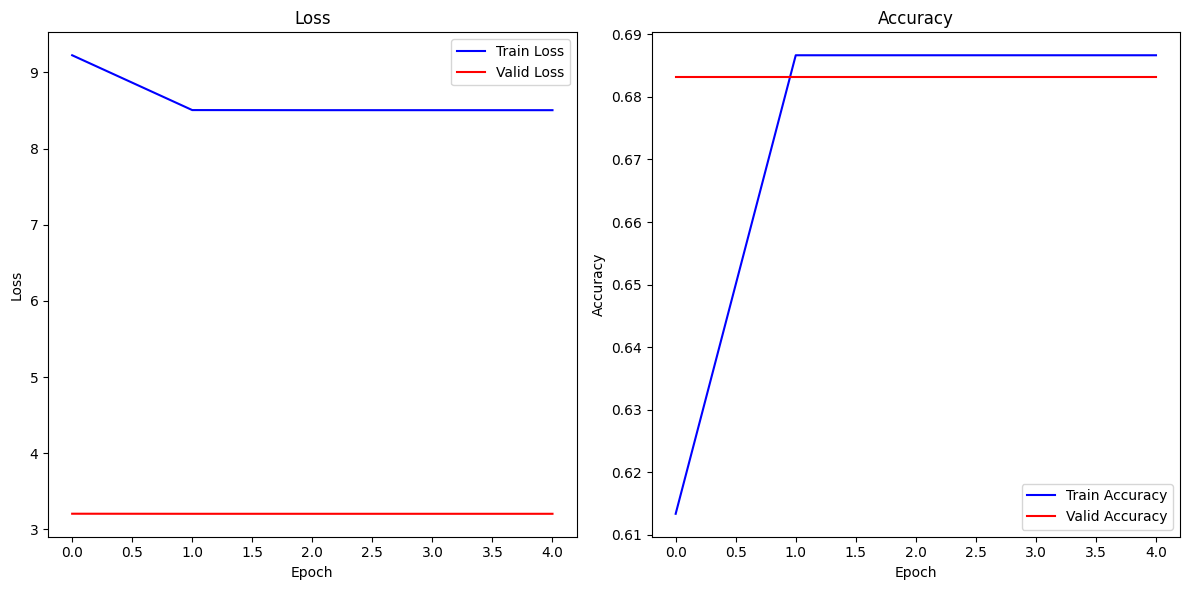

outputs_all shape 101 3
targets_all shape 101
Accuracy: 0.6832
Balanced Accuracy: 0.3333
F1: 0.5546
ROC AUC: 0.4617
Precision: 0.4667
Recall: 0.6832


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


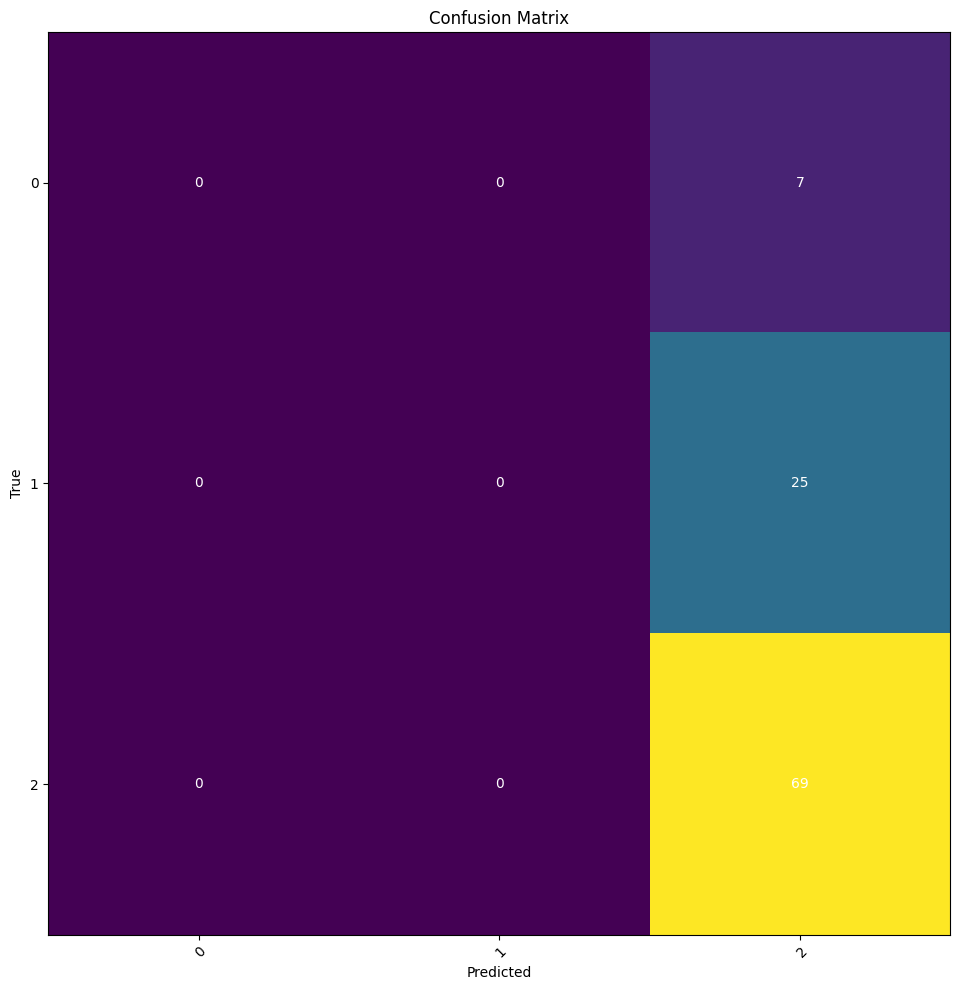

In [63]:
bert_effectiveness_model, bert_effectiveness_train_metrics = run_training(
    model_path="./models/bert_effectiveness_model.pth",
    model=BERTClassification(n_classes=DATALOADER_CONFIGS["effectiveness"]["num_encoded_labels"]),
    train_dataloader=mini_bert_effectiveness_train_dataloader,
    test_dataloader=mini_bert_effectiveness_test_dataloader,
    epochs=5,
    lr=0.001,
    save_model=True
)

plot_losses(bert_effectiveness_train_metrics)

bert_effectiveness_test_metrics = test_model(
    bert_effectiveness_model,
    mini_bert_effectiveness_test_dataloader
)

plot_metrics(bert_effectiveness_test_metrics)


Training ./models/bert_side_effects_model.pth model...
[1/5] | Train Loss: [10.1799] | Train Accuracy: [0.5367] | Valid Loss: [4.3175] | Valid Accuracy: [0.5446]
[2/5] | Train Loss: [10.0759] | Train Accuracy: [0.5467] | Valid Loss: [4.3182] | Valid Accuracy: [0.5446]
[3/5] | Train Loss: [10.0766] | Train Accuracy: [0.5467] | Valid Loss: [4.3182] | Valid Accuracy: [0.5446]
[4/5] | Train Loss: [10.0767] | Train Accuracy: [0.5467] | Valid Loss: [4.3182] | Valid Accuracy: [0.5446]
[5/5] | Train Loss: [10.0768] | Train Accuracy: [0.5467] | Valid Loss: [4.3182] | Valid Accuracy: [0.5446]


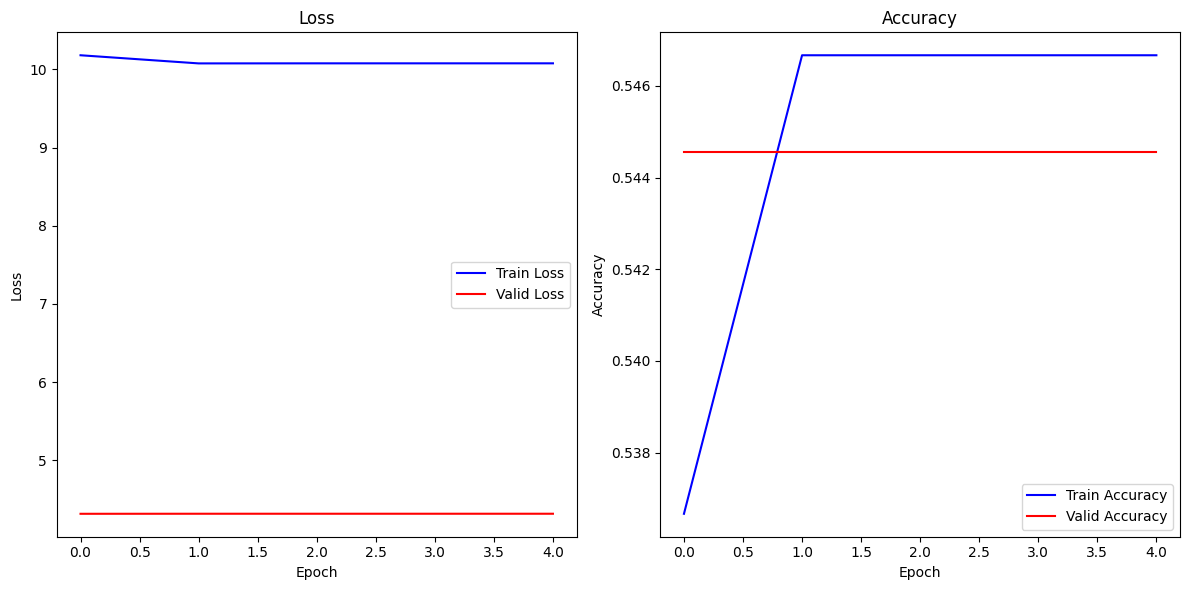

outputs_all shape 101 3
targets_all shape 101
Accuracy: 0.5446
Balanced Accuracy: 0.3333
F1: 0.3840
ROC AUC: 0.5119
Precision: 0.2965
Recall: 0.5446


/Users/batiukmaks/PycharmProjects/Neural-Network-Technologies-and-Their-Usage-Labs/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


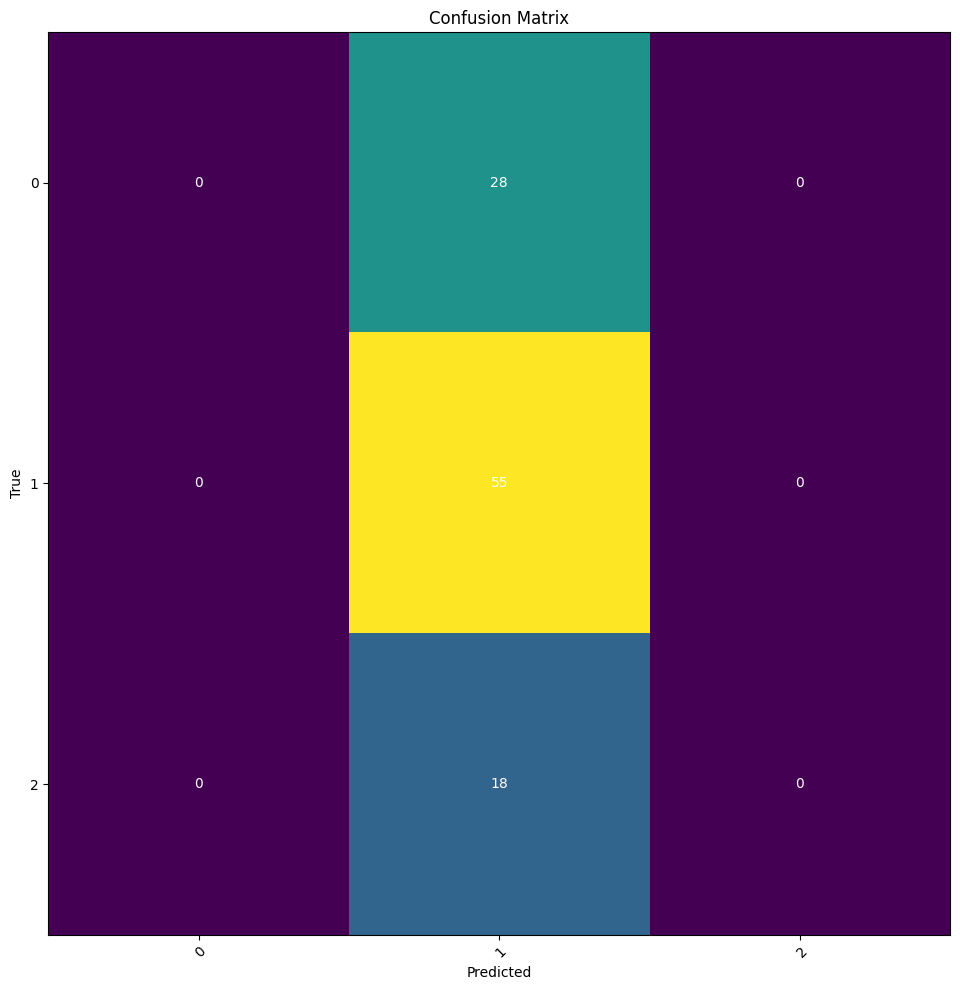

In [64]:
bert_side_effects_model, bert_side_effects_train_metrics = run_training(
    model_path="./models/bert_side_effects_model.pth",
    model=BERTClassification(n_classes=DATALOADER_CONFIGS["sideEffects"]["num_encoded_labels"]),
    train_dataloader=mini_bert_side_effects_train_dataloader,
    test_dataloader=mini_bert_side_effects_test_dataloader,
    epochs=5,
    lr=0.001,
    save_model=True
)

plot_losses(bert_side_effects_train_metrics)

bert_side_effects_test_metrics = test_model(
    bert_side_effects_model,
    mini_bert_side_effects_test_dataloader
)

plot_metrics(bert_side_effects_test_metrics)